# Orbital Mechanics for a Solar Sail

This notebook was created for the simulation of a solar sail in various orbital systems.

## Imports

There are various libraries that must be imported for the simulation of coupled ODEs

In [4]:
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import scipy.fft as fft

## Utility Functions

We define some uility functions for future use.

In [18]:
def polarToCartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def cartesianToPolar(x,y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return (radius, theta)

def polarVelocityToCartesianVelocity(r,rdot,theta,thetadot):
    xdot = rdot * np.cos(theta) - r * thetadot * np.sin(theta)
    ydot = rdot * np.sin(theta) + r * thetadot * np.cos(theta)
    
    return xdot, ydot

## Universal Constants

There are some universal constants which remain the same no matter the system and we define them here at a top level for future use.

In [19]:
G_CONSTANT = 6.67e-11
C_CONSTANT = 299792458
L0_CONSTANT = 3.83e26
SOLAR_MASS_CONSTANT = 1.99e30
EARTH_MASS_CONSTANT = 5.97e24
MARS_MASS_CONSTANT = 6.39e23

## Sail Parameters

For our sail, we consider common design trends and come up with parameters based on these for three different designs. The first being a small 'concept' sail, a larger sail for interplanetary travel and an even larger sail for interstellar travel. 
* In terms of reflectivity, most sails use an aluminium layer of thickness 20 nm or more. This achieves a reflectivity of between 0.88 and 0.9. Thus we base our parameter for the concept and interplanetary designs on the average of these two. I.e. 0.89. For the interstellar vehicle, we assume some progress in technology and thus aim for a reflectivity of 0.95.
* For area and mass. We consider their ratio. The IKAROS mission had a mass of 315 kg, an area of 14x14 metres and thus a ratio of 196:315 so we use this for the concept sail. For interstellar designs a ratio of 12960:1 is cited by Robert L. Forward. Thus, for the interplanetary sail we take a value imbetween these of 1000:1.


In [20]:
concept_sail_reflectivity = 0.89
planetary_sail_reflectivity = 0.89
stellar_sail_reflectivity = 0.95

concept_sail_mass_to_area = 1/0.622
planetary_sail_mass_to_area = 1/1000
stellar_sail_mass_to_area = 1/12960

## 2 Bodies: Sun and Sail

For this our two equations are as follows:

$$\ddot r = r \dot \theta^2 + \frac{G M}{r^2} + \frac{\left(1 + R \cos(2 \phi) \right) L_0 A}{4 c m \pi r^2} \cos(\phi)$$

$$\ddot \theta = - \frac{2 \dot r \dot \theta}{r} - \frac{R \sin(2 \phi) L_0 A}{4 c \pi m r^3} \cos(\phi)$$

However, we group parameters in such a way by setting:

$$\tau = t_c t, \text{ where: } t_c = 31536000 \\$$
$$\tilde{r} = r_c r, \text{ where: } r_c = 1.495978707 \cdot 10^{11}$$ 

So as to produce:

$$\tilde{r}^2 \frac{d^2 \tilde{r}}{d \tau^2} = \tilde{r}^3 \left(\frac{d \theta}{d \tau}\right)^2 + \alpha \sigma \left(1 + R \cos(2 \phi) \right) \cos(\phi) + \beta $$
$$\tilde{r}^3 \frac{d^2 \theta}{d \tau^2} = - 2 \tilde{r}^2 \frac{d \tilde{r}}{d \tau} \frac{d \theta}{d \tau} - \alpha \sigma R \sin(2 \phi) \cos(\phi)$$

Where:

$$\alpha = \frac{t_c^2}{r_c^3} \frac{L_0}{4 c \pi}$$
$$\beta = \frac{t_c^2}{r_c^3} GM$$
$$\sigma = \frac{m}{A}$$

In [21]:
ts = 365 * 24 * 60 * 60
rs = 1.495978707e11

In [22]:
alpha = ((ts**2)/(rs**3)) * (L0_CONSTANT / (4 * C_CONSTANT * math.pi))
beta = ((ts**2)/(rs**3)) * G_CONSTANT * SOLAR_MASS_CONSTANT

In [23]:
def twoBodyODE(y,t,R,sigma,phi):
    r = y[0]
    rdot = y[1]
    theta = y[2]
    thetadot = y[3]
    
    rddot = r * (thetadot**2) + r**(-2) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi) - (beta / r**2)
    thetaddot = ((-2)/r) * rdot * thetadot - r**(-3) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    return [rdot, rddot, thetadot, thetaddot]

def noGravitationalPotentialTwoBodyODE(y,t):
    beta = 0
    
    r = y[0]
    rdot = y[1]
    theta = y[2]
    thetadot = y[3]
    
    rddot = r * (thetadot**2) - (beta / r**2)
    thetaddot = ((-2)/r) * rdot * thetadot
    
    return [rdot, rddot, thetadot, thetaddot]

### Initial Conditions and Arguments

We have our concept solar sail initially going around the sun at Earth's orbital radius with an initial velocity equivalent to that of the planet. 

In [24]:
r0, rdot0, theta0, thetadot0 = 1, 0, 0, 2 * math.pi
y0 = [r0,rdot0,theta0,thetadot0]

### Limiting Cases

To solve the ODEs we use a function called odeint from the scipy library and do so in the following limiting cases:
1. No gravitational potential or radiation pressure which should lead to a straight line path
2. High mass to area and no tangential force which should result in the orbit of Earth

In [25]:
t = np.linspace(0, 1,1000)

yL1 = odeint(noGravitationalPotentialTwoBodyODE, y0,t)
yL2 = odeint(twoBodyODE, y0,t, args=(0, 5e8,(1/2 * np.pi)))

rL1, rdotL1, thetaL1, thetadotL1 = yL1[:,0], yL1[:,1], yL1[:,2], yL1[:,3]
rL2, rdotL2, thetaL2, thetadotL2 = yL2[:,0], yL2[:,1], yL2[:,2], yL2[:,3]

### Plotting Limiting Cases

We convert back to cartesian to plot the results.

In [26]:
(xL1,yL1) = polarToCartesian(rL1,thetaL1)
(xL2,yL2) = polarToCartesian(rL2,thetaL2)

### Plotting Orbital Radius as a Function of Time

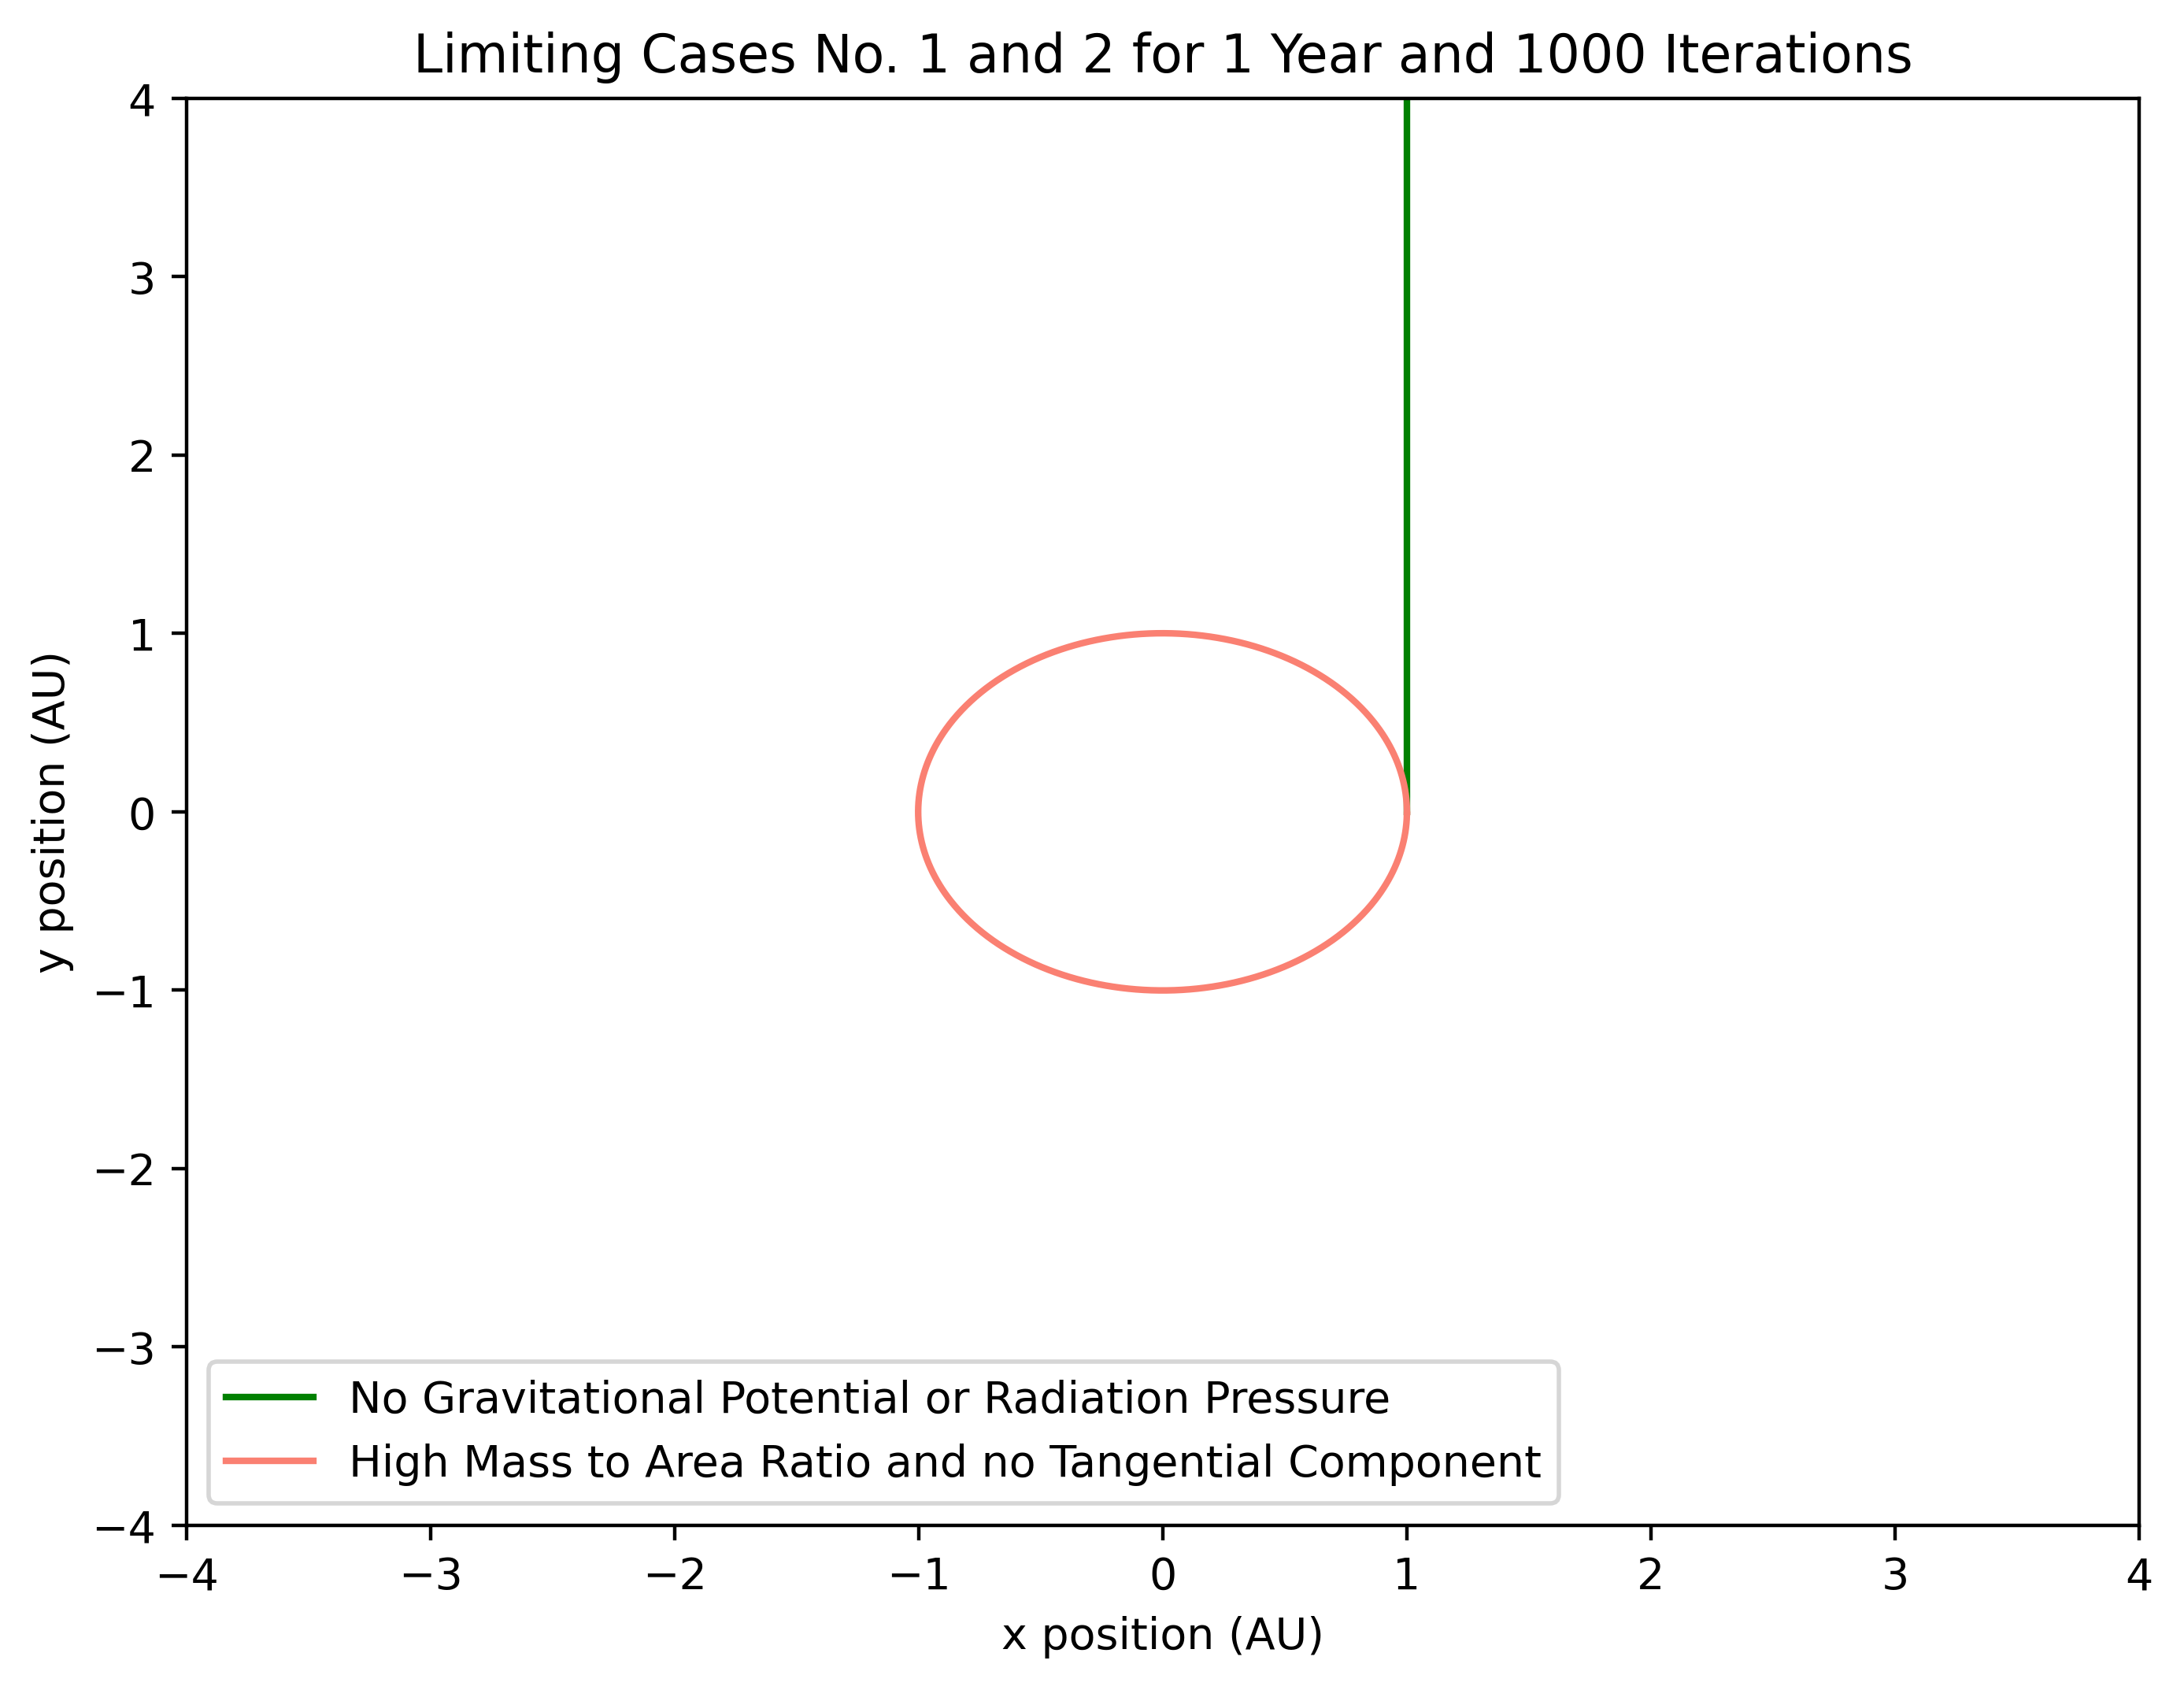

In [27]:
fig = plt.figure(figsize=(8, 6), dpi=400)
plt.plot(xL1,yL1, c='g', label='No Gravitational Potential or Radiation Pressure')
plt.plot(xL2,yL2, c='salmon', label='High Mass to Area Ratio and no Tangential Component')
plt.title("Limiting Cases No. 1 and 2 for 1 Year and 1000 Iterations")
plt.xlabel("x position (AU)")
plt.ylabel("y position (AU)")
plt.legend()
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.savefig('limiting cases.png')
plt.show()

## Testing the Ejection Hypothesis

We may test the ejection hypothesis by altering one of $R$, $\sigma$ or $\phi$ such that the pressure term is just below and above that of $\beta$. Then we graph the vector field and an orbit within the field in both cases. For our analysis we choose $R = 1$, $\phi = \frac{\pi}{2}$ and $\sigma$ to be either $4 \cdot 10^{-3}$ or $2 \cdot 10^{-3}$.

In [28]:
def plotTwoBodyVectorField(params, xlim, ylim):

    t = np.linspace(0,10,100)
    
    # We don't include x and y values between that of -0.1 and 0.1 as these explode close to the sun.
    xVectors = np.concatenate((np.linspace(-xlim,0,10),np.linspace(0,xlim,10)), axis=0)
    yVectors = np.concatenate((np.linspace(-ylim,0,10),np.linspace(0,ylim,10)), axis=0)

    # Create a mishgrid for later plotting
    X,Y = np.meshgrid(xVectors, yVectors)

    U = []
    V = []
    
    # Enumerate and calculate velocity vectors
    for x in xVectors:
        for y in yVectors:
            r0, theta0 = cartesianToPolar(x,y)
            y0 = [r0, 0, theta0, 0]
            
            y = odeint(twoBodyODE,y0, t, args=params)
            
            r, rdot, theta, thetadot = y[99,0], y[99,1], y[99,2], y[99,3]
            
            xdot, ydot = polarVelocityToCartesianVelocity(r, rdot, theta, thetadot)
            
#             print(xdot,ydot)
            
            N = np.sqrt(xdot**2+ydot**2)
            U.append(xdot/N)
            V.append(ydot/N)
    
    fig = plt.figure(figsize=(8, 6), dpi=400)

    plt.quiver(X,Y,U,V, color='black', scale=100, zorder=0)

    plt.title("Vector Field")
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.xlim(-2,2)
    plt.ylim(-2,2)

In [29]:
def plotTrajectoriesSunAndSail(iterations, args, temporalLength, calcLim, graphLim, color):
    
    t = np.linspace(0,temporalLength, iterations)
    
    # We plot more paths than vectors
    xPaths = np.concatenate((np.linspace(-calcLim,-0.2,5),np.linspace(0.2,calcLim,5)), axis=0)
    yPaths = np.concatenate((np.linspace(-calcLim,-0.2,5),np.linspace(0.2,calcLim,5)), axis=0)

#     # We don't include x and y values between that of -0.1 and 0.1 as these explode close to the sun.
#     xVectors = np.concatenate((np.linspace(-xlim,-0.1,10),np.linspace(0.1,xlim,10)), axis=0)
#     yVectors = np.concatenate((np.linspace(-ylim,-0.1,10),np.linspace(0.1,ylim,10)), axis=0)

#     # Create a mishgrid for later plotting
#     X,Y = np.meshgrid(xVectors, yVectors)

#     U = []
#     V = []

    pathGrid = []

    # Enumerate and integrate paths
    for i,x in enumerate(yPaths):
        for j,y in enumerate(yPaths):
            r0, theta0 = cartesianToPolar(x,y)
            path = odeint(twoBodyODE, [r0,0,theta0,0.05], t, args=args)
            pathGrid.append(path)
            
    fig = plt.figure(figsize=(8, 6), dpi=400)

    for path in pathGrid:
        (x,y) = polarToCartesian(path[:,0], path[:,2])
        plt.plot(x, y, c=color, zorder=0)

    plt.title(f"Trajectories for $R = $ {args[0]}, $\sigma = $ {args[1]} and $\phi = $ {args[2]}")
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.xlim(-graphLim,graphLim)
    plt.ylim(-graphLim,graphLim)
    plt.savefig(f"Trajectories for R {args[0]}, sigma {args[1]} and phi {args[2]}.png")
    plt.show()

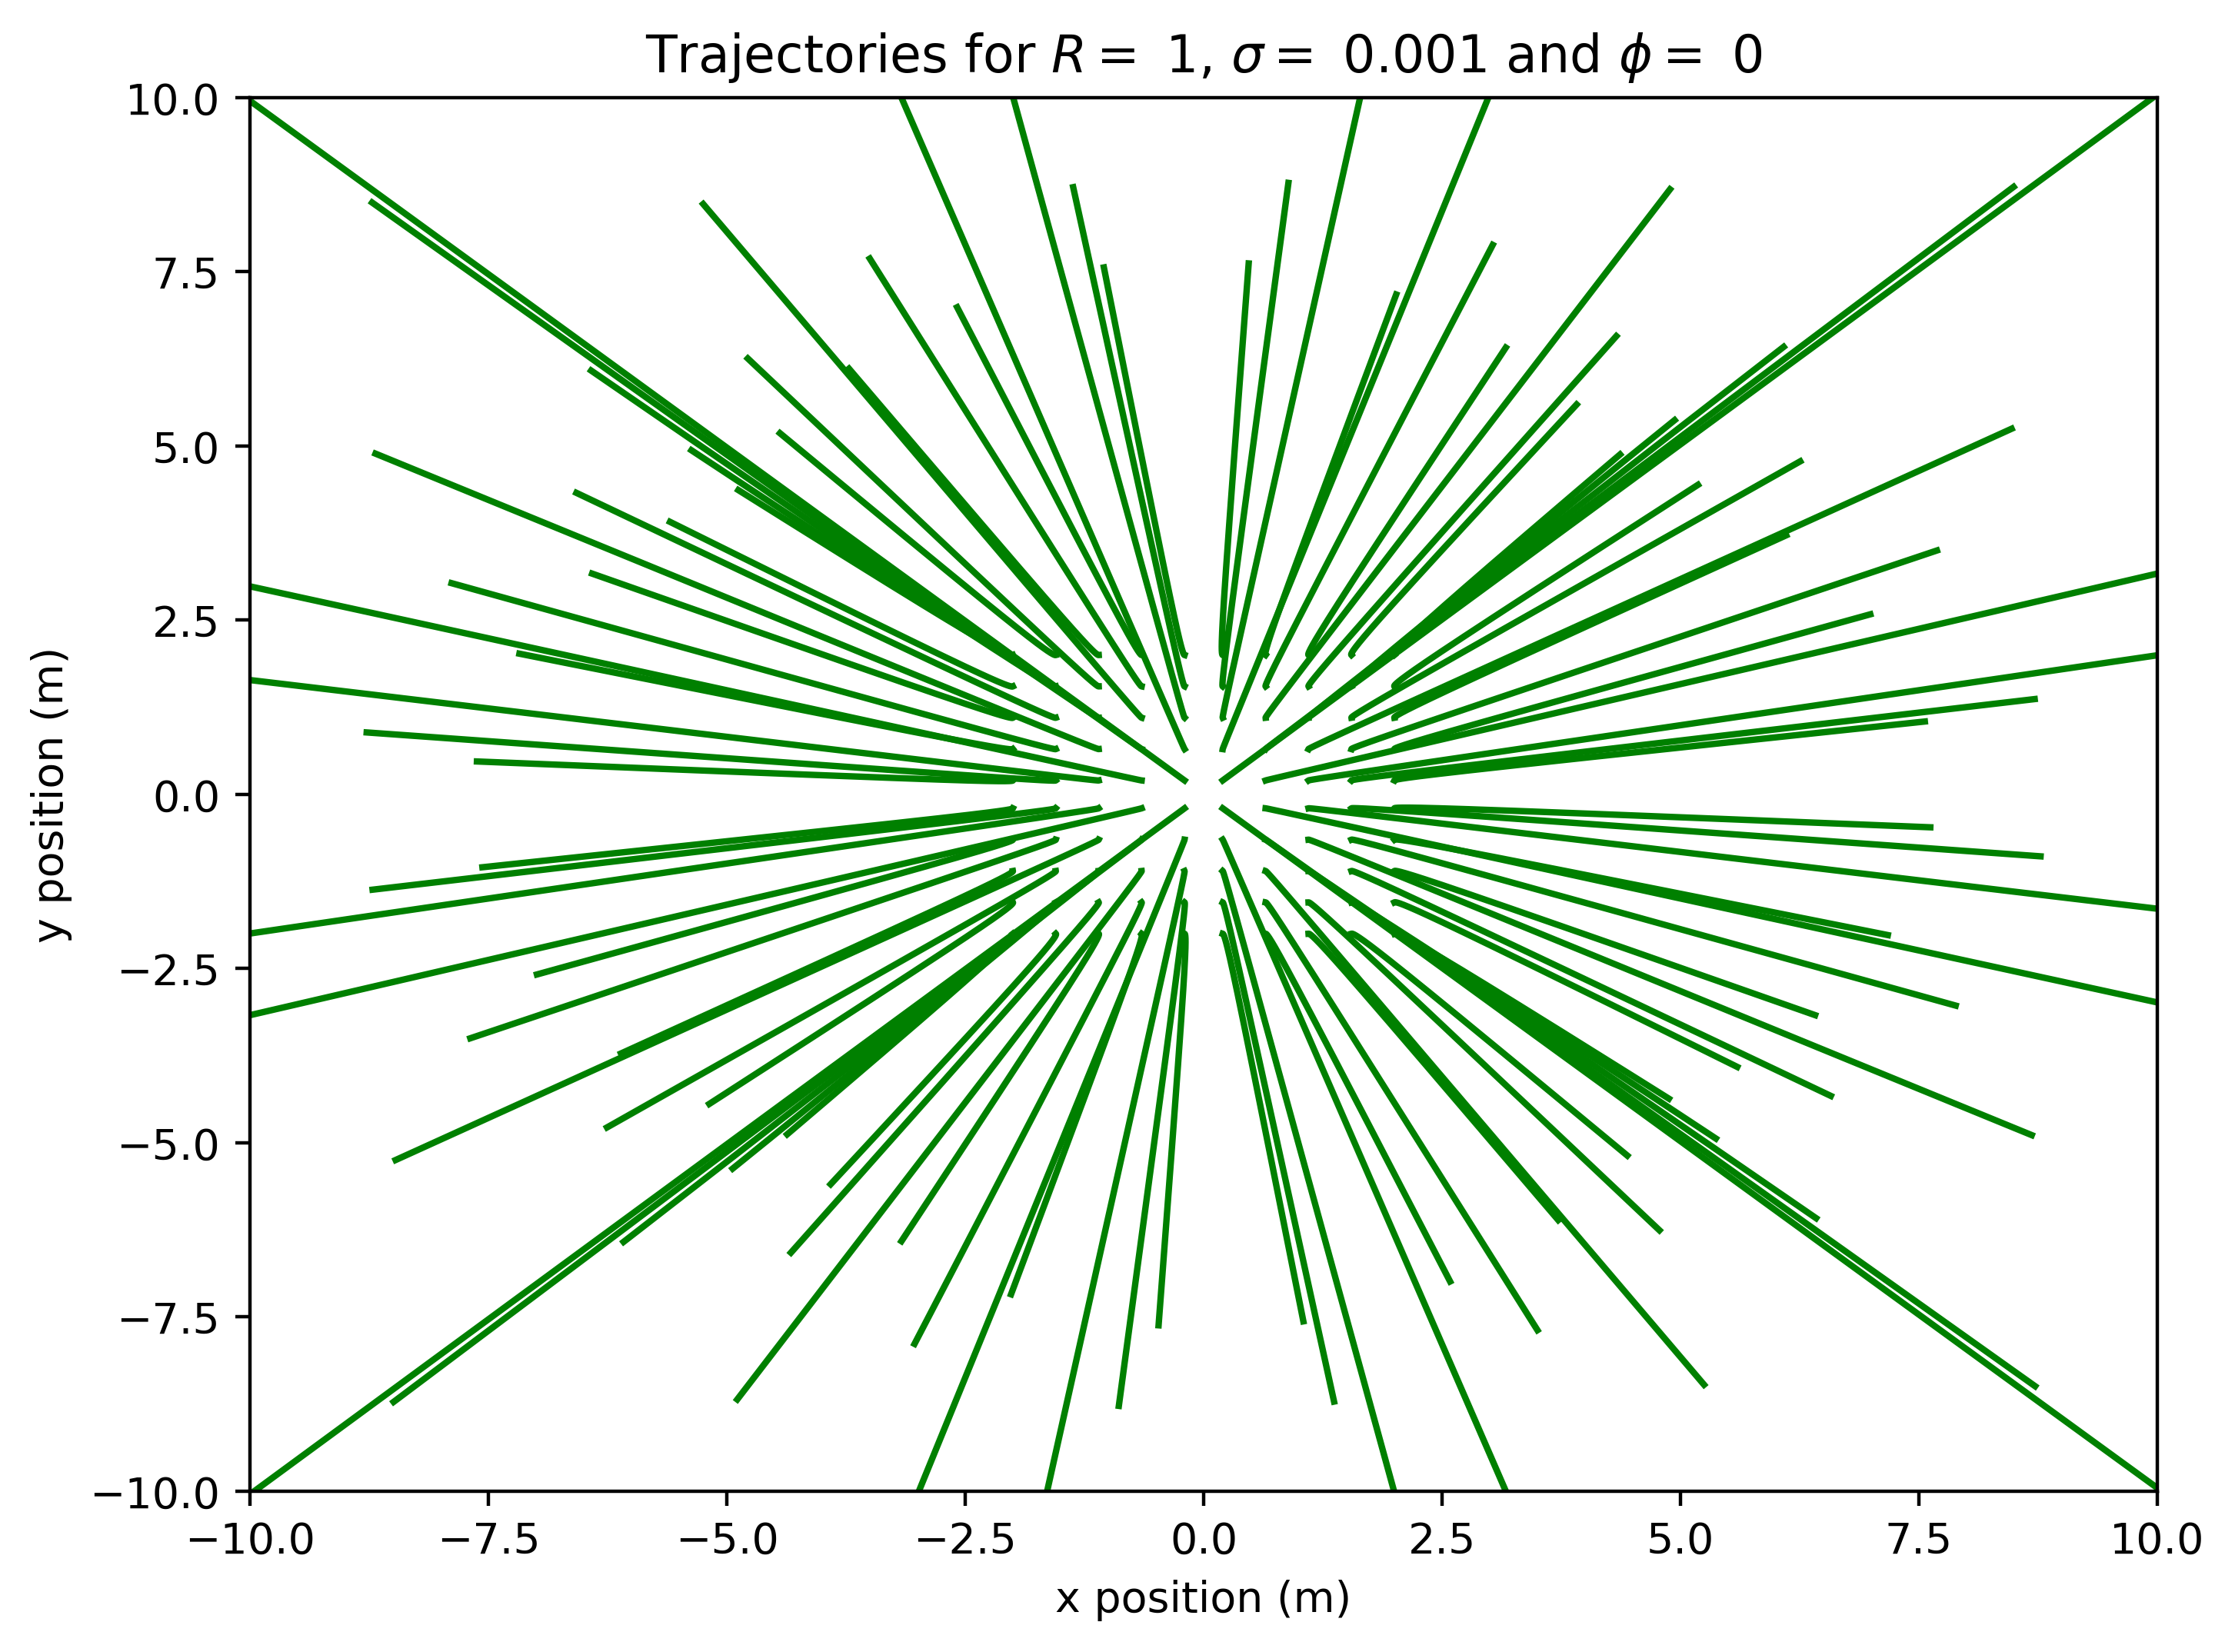

/Users/jackmiller/miniforgeRosetta/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


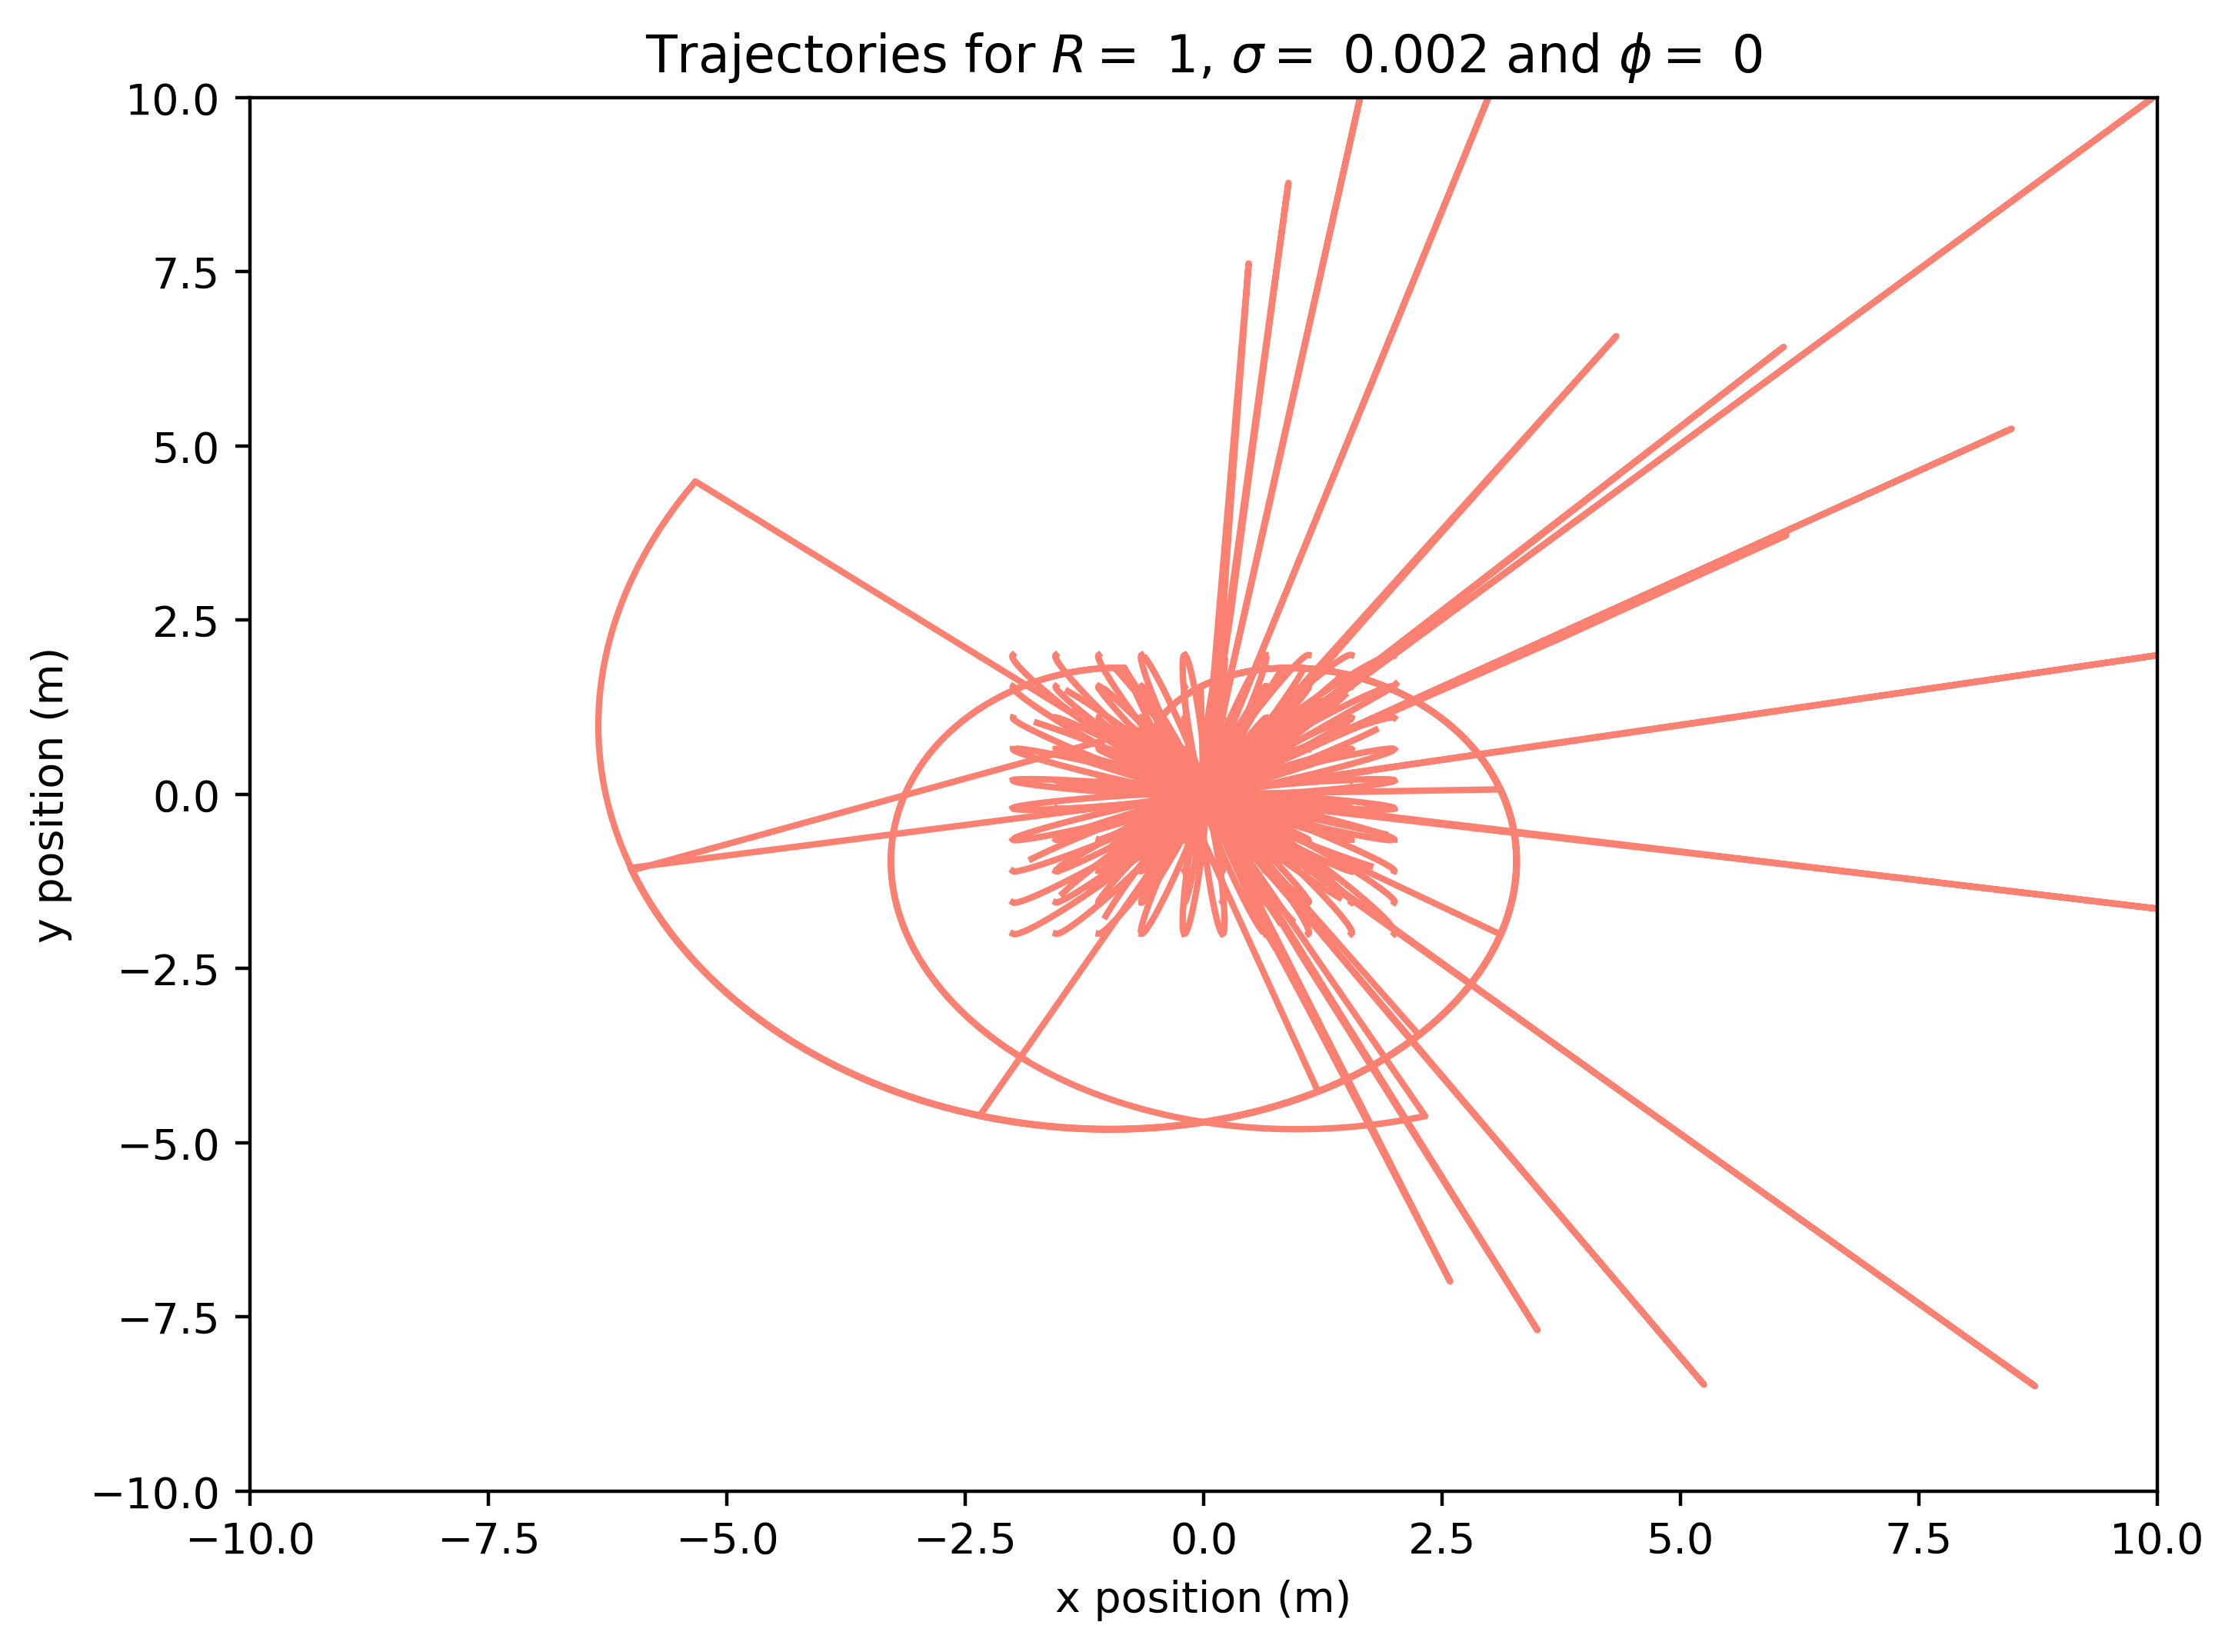

In [30]:
plotTrajectoriesSunAndSail(1000,(1, 1e-3,0), 2, 2, 10, 'g')
plotTrajectoriesSunAndSail(1000,(1, 2e-3,0), 2, 2, 10, 'salmon')

In [15]:
t = np.linspace(0, 10,3000)

grain = 30

R_array = np.linspace(0,1,grain)
sigma_array = np.linspace(1e-3,10e-3, grain)
results = np.arange(grain*grain).reshape(grain,grain)

for j, sigma_value in enumerate(sigma_array):
    for i, R_value in enumerate(R_array):
        solution = odeint(twoBodyODE, y0,t, args=(R_value, sigma_value,0))
        r, rdot, theta, thetadot = solution[:,0], solution[:,1], solution[:,2], solution[:,3]
        results[j][i] = r[2*1000]

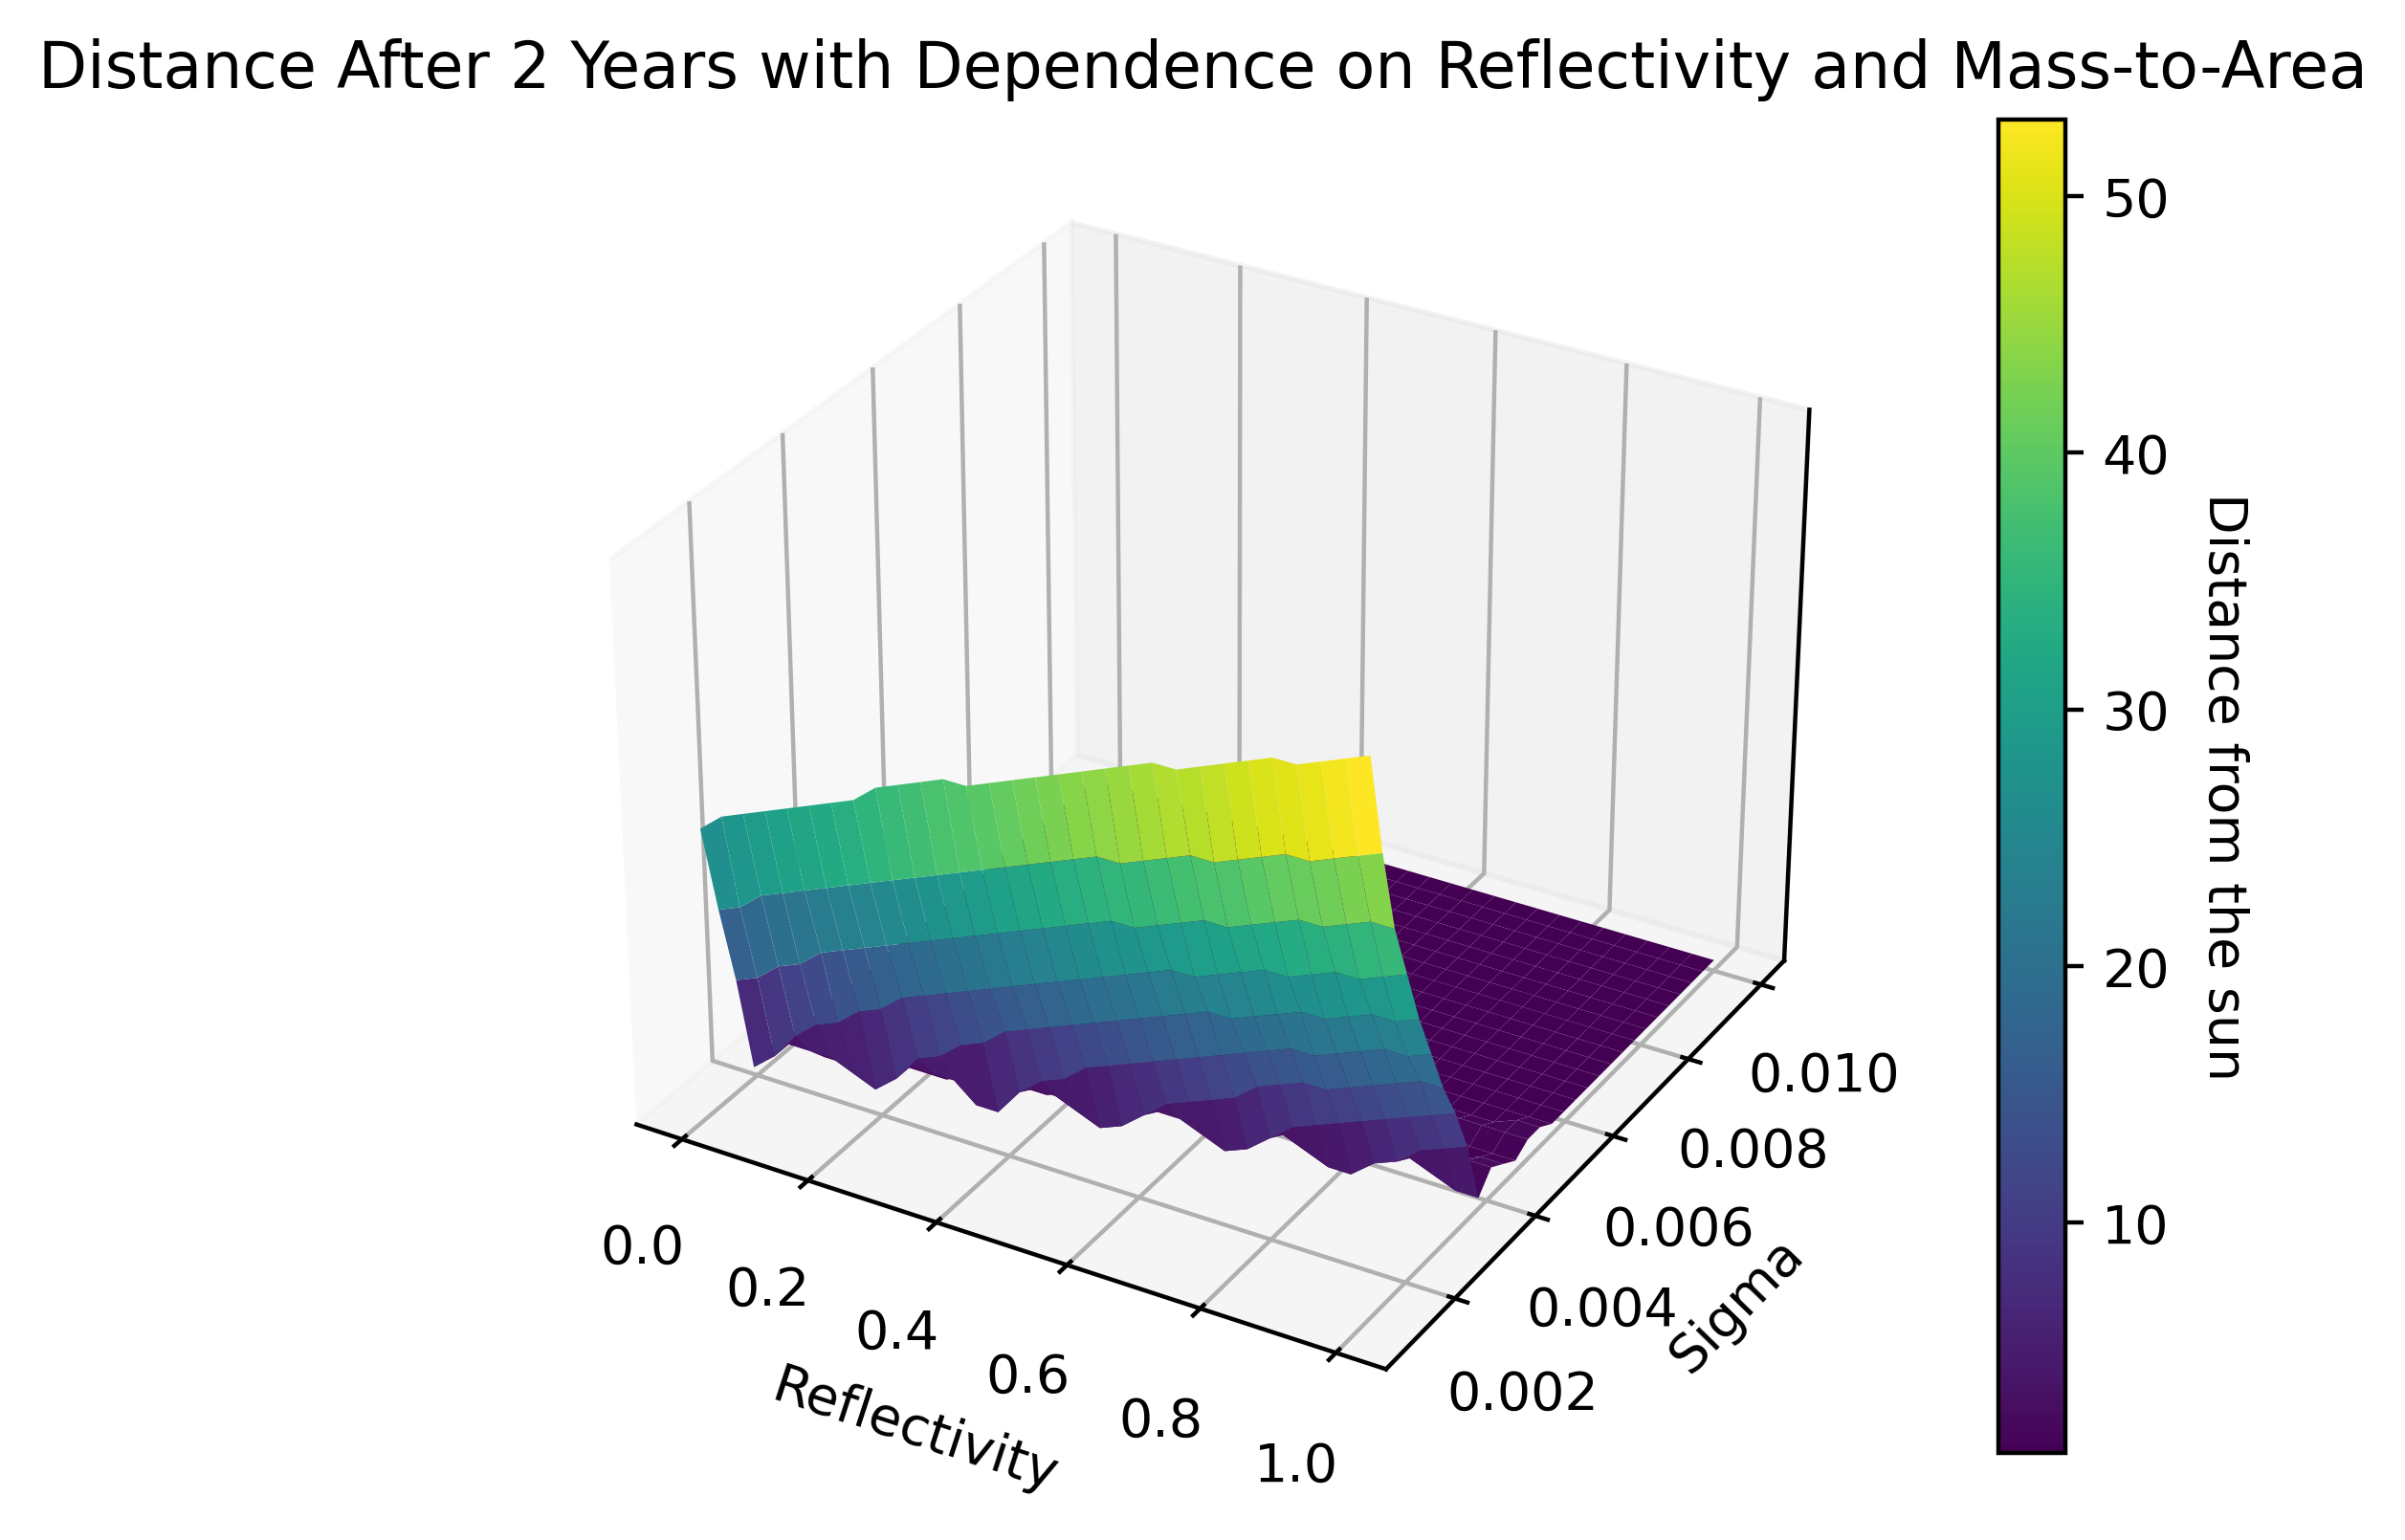

In [16]:
fig = plt.figure(figsize=(7,4), dpi=400)
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(R_array, sigma_array)

surf = ax.plot_surface(X, Y, results, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf)
cbar.set_label('Distance from the sun', rotation=270, labelpad=15)
plt.title("Distance After 2 Years with Dependence on Reflectivity and Mass-to-Area")
ax.set_xlabel('Reflectivity')
ax.set_ylabel('Sigma')
ax.axes.get_zaxis().set_ticks([])
plt.tight_layout()
fig.savefig('meshplot.png')
plt.show()

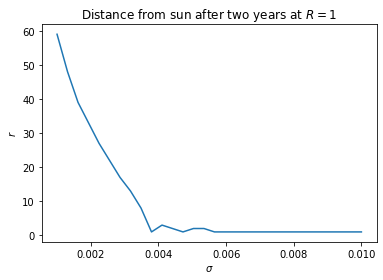

In [17]:
plt.plot(sigma_array,results[:,29])
plt.title("Distance from sun after two years at $R=1$")
plt.xlabel("$\sigma$")
plt.ylabel("$r$")
plt.show()

## Orbit Raising with $\phi$

We model orbit raising by first setting $R$ and $\sigma$ values which do not lead to ejection (namely $R=0.7$ and $\sigma = 8 \cdot 10^{-3}$ and use Earth's initial conditions. Then, we set $\phi = -\frac{\pi}{4}$ when $-\frac{\pi}{6} \leq \theta \leq \frac{\pi}{6}$ and $\phi = \frac{\pi}{2}$ elsewhere. We choose the second value for $\phi$ as this state leads to no pressure contribution radially or tangentially. Indeed, it is analogous to turning off a traditional rocket engine.

In [18]:
def thetaRangeAccel(theta):
    theta = theta % (2 * math.pi)
    if (theta < math.pi/6 and theta > -math.pi/6):
        return (-math.pi/4)
    else:
        return (math.pi/2)

In [19]:
def twoBodyODEPhiDependence(y,t,R,sigma,phiFunc):
    r = y[0]
    rdot = y[1]
    theta = y[2]
    thetadot = y[3]
    
    phi = phiFunc(theta)
    
    rddot = r * (thetadot**2) + r**(-2) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi) - (beta / r**2)
    thetaddot = ((-2)/r) * rdot * thetadot - r**(-3) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    return [rdot, rddot, thetadot, thetaddot]

In [20]:
r0, rdot0, theta0, thetadot0 = 1, 0, 0, 2 * math.pi
y0 = [r0,rdot0,theta0,thetadot0]

t = np.linspace(0, 10,1000)

yOR = odeint(twoBodyODEPhiDependence, y0,t, args=(0.7, 8e-3,thetaRangeAccel))

rOR1, rdotOR1, thetaOR1, thetadotOR1 = yOR[:,0], yOR[:,1], yOR[:,2], yOR[:,3]

In [21]:
(xOR1, yOR1) = polarToCartesian(rOR1,thetaOR1)

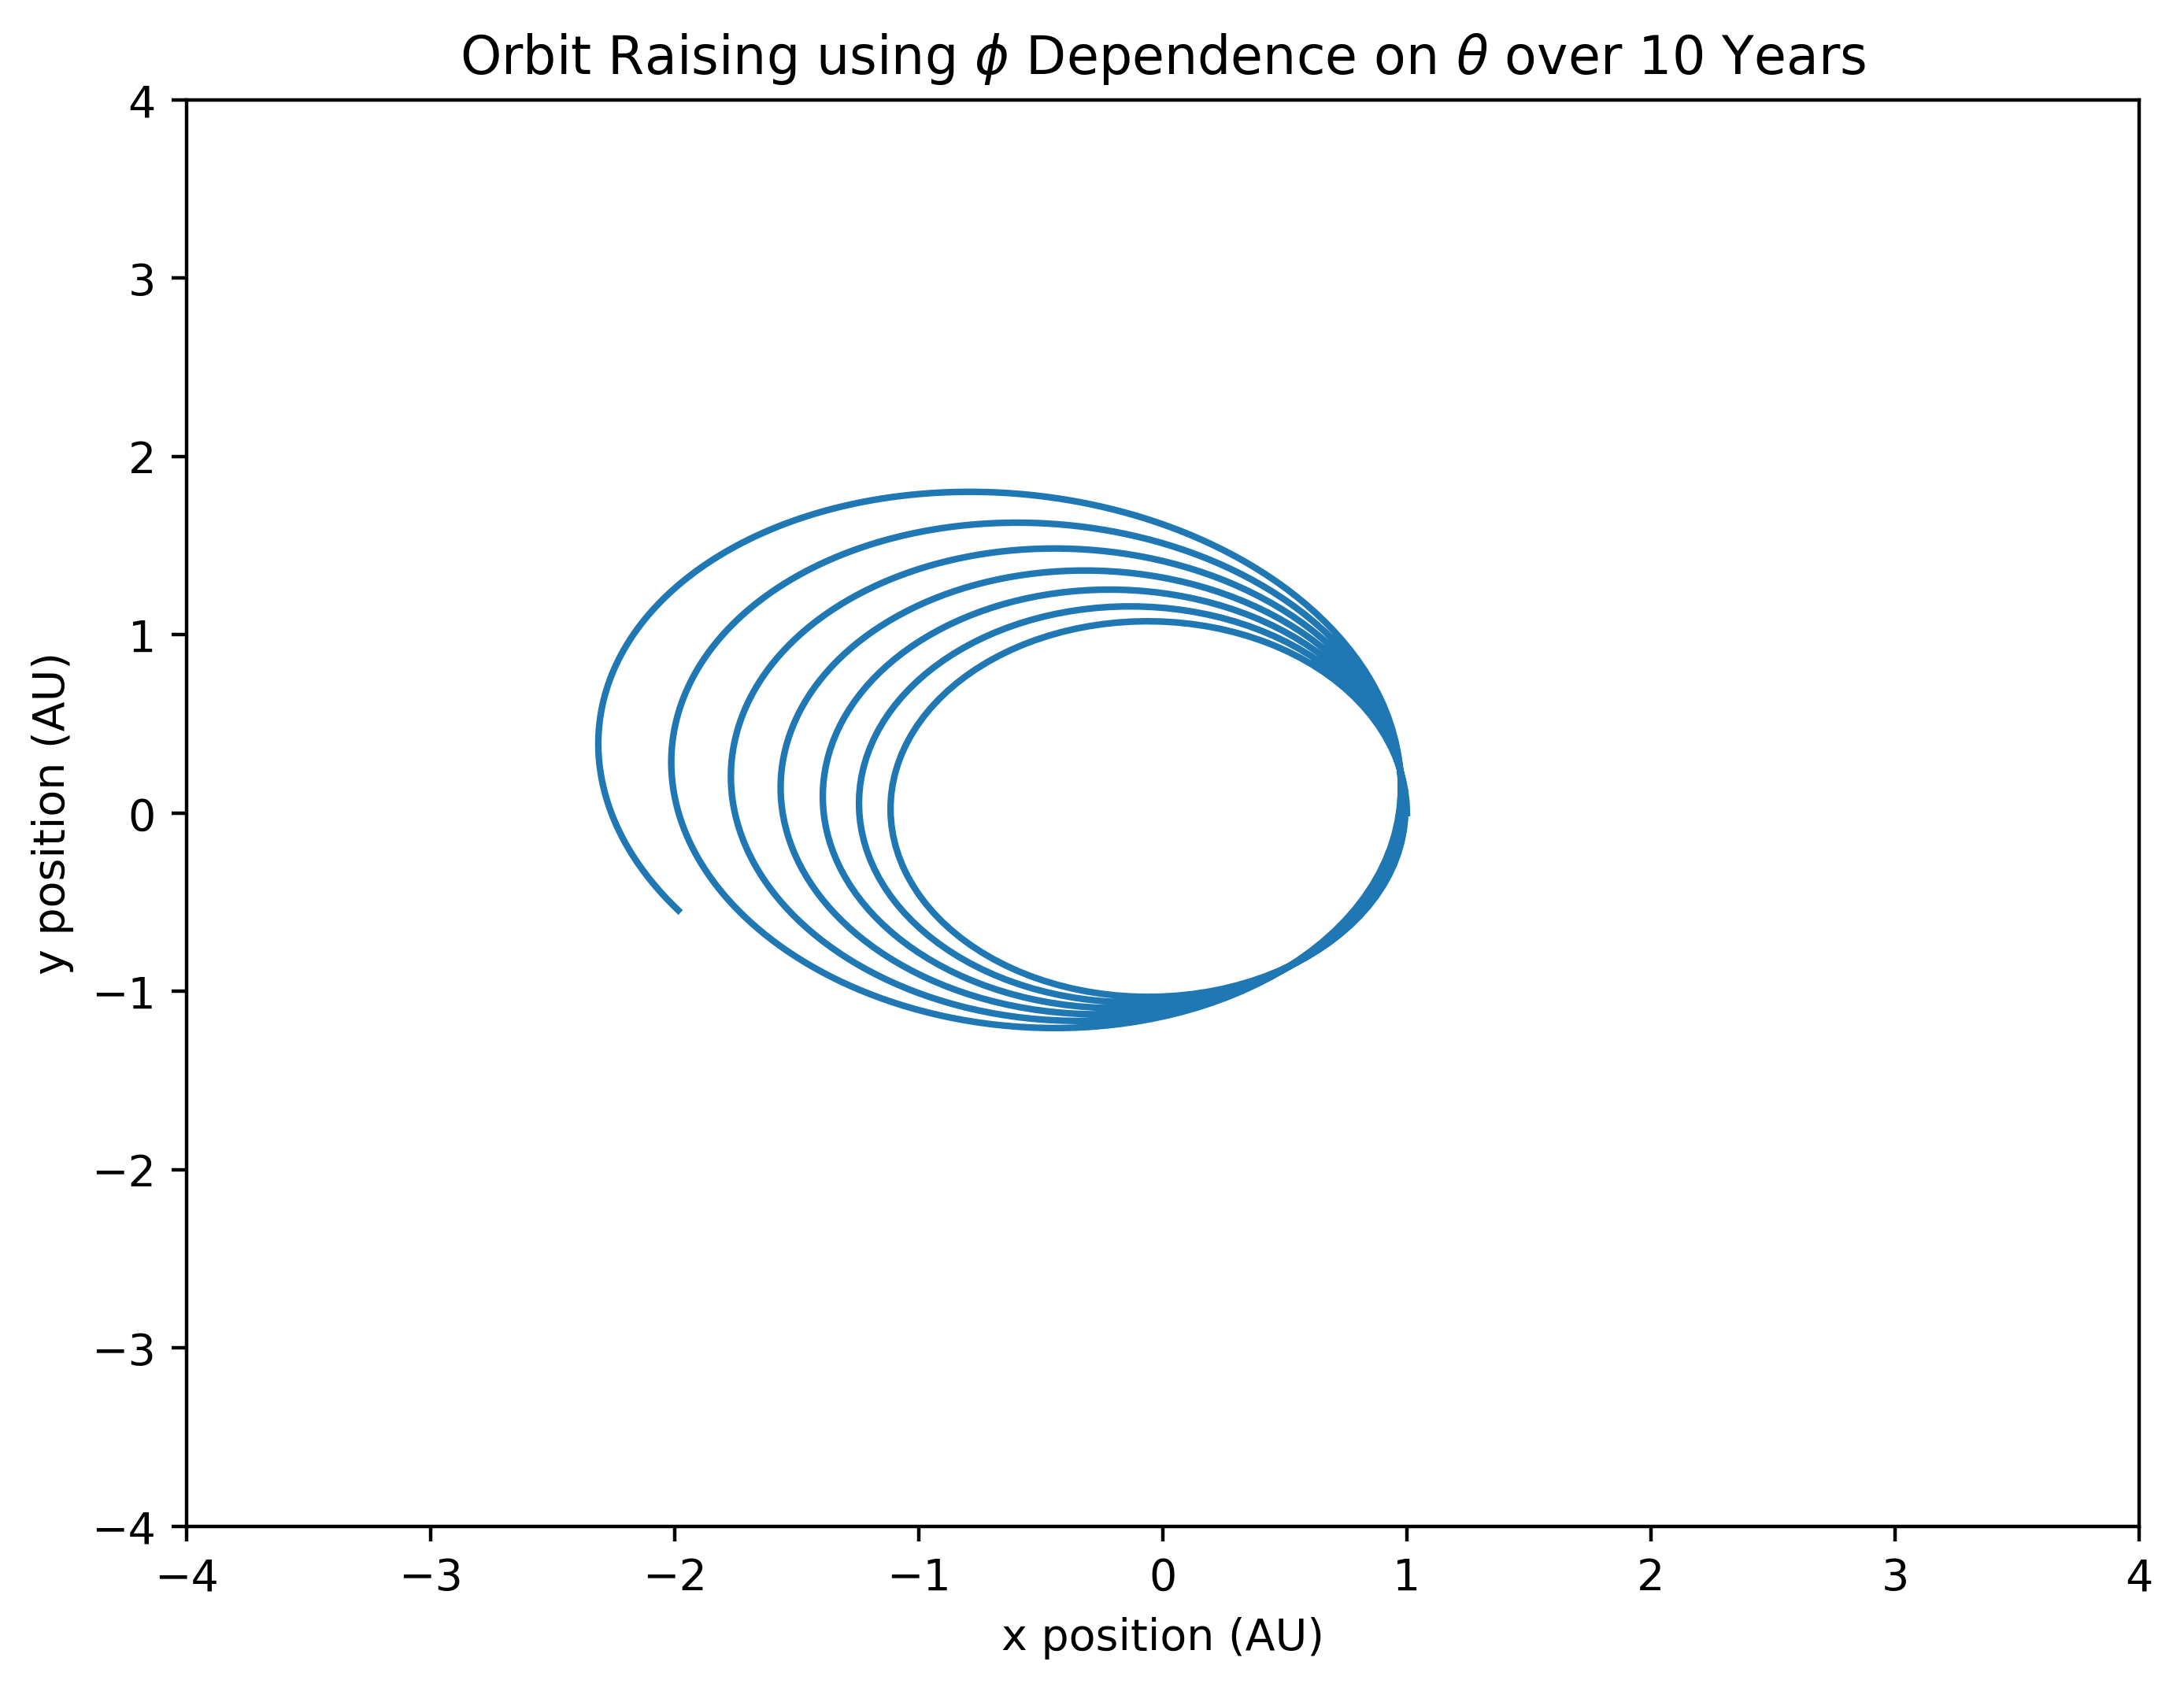

In [22]:
fig = plt.figure(figsize=(8, 6), dpi=400)
plt.plot(xOR1, yOR1)
plt.title(r"Orbit Raising using $\phi$ Dependence on $\theta$ over 10 Years")
plt.xlabel("x position (AU)")
plt.ylabel("y position (AU)")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.savefig('piecewise phi.png')
plt.show()

## 4 Bodies: Sun, Earth, Mars and Sail

### Generating Function for ODEs

Below we wish to create a function which can produce arbitrarily many additional planets and model them idnividually.

In [23]:
def polarDistance(r1,r2,theta1,theta2):
    return math.sqrt(r1**2 + r2**2 - 2 * r1 * r2 * math.cos(theta1 - theta2))

def g1(r1,r2,theta1,theta2):
    return ((r1 - r2 * math.cos(theta1-theta2)) / ((r1**2 + r2**2 - 2 * r1 * r2 * \
            math.cos(theta1 - theta2))**(3/2)))

def g2(r1,r2,theta1,theta2):
    return (r2 * math.sin(theta1 - theta2)) / (r1*(r1**2 + r2**2 - 2 * r1 * r2 * \
            math.cos(theta1 - theta2))**(3/2))

In [24]:
beta_1 = (ts**2)/(rs**3) * G_CONSTANT * SOLAR_MASS_CONSTANT
beta_2 = (ts**2)/(rs**3) * G_CONSTANT * EARTH_MASS_CONSTANT
beta_3 = (ts**2)/(rs**3) * G_CONSTANT * MARS_MASS_CONSTANT

In [25]:
def fourBodyODEs(x,t,R,sigma,phi):
    r = x[0]
    r_dot = x[1]
    theta = x[2]
    theta_dot = x[3]
    r_e = x[4]
    r_e_dot = x[5]
    theta_e = x[6]
    theta_e_dot = x[7]
    r_m = x[8]
    r_m_dot = x[9]
    theta_m = x[10]
    theta_m_dot = x[11]

    r_ddot = r * theta_dot**2 +  - (beta_1) /r**2 - beta_2 * g1(r,r_e,theta,theta_e) - beta_3 * g1(r,r_m,theta,theta_m) \
                + (r**(-2)) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi)
    
    theta_ddot = (-2/r) * r_dot * theta_dot - beta_2 * g2(r, r_e, theta, theta_e) - beta_3 * g2(r,r_m,theta,theta_m) \
                - (r**(-3)) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    r_e_ddot = r_e * (theta_e_dot)**2 - beta_1 / r_e**2 - beta_3 * g1(r_e, r_m, theta_e, theta_m)
    
    theta_e_ddot = - (2 / r_e) * r_e_dot * theta_e_dot - beta_3 * g2(r_e,r_m,theta_e,theta_m)
    
    r_m_ddot = r_m * (theta_m_dot)**2 - beta_1 / r_m**2 - beta_2 * g1(r_m, r_e, theta_m, theta_e)
    
    theta_m_ddot = - (2 / r_m) * r_m_dot * theta_m_dot - beta_2 * g2(r_m,r_e,theta_m,theta_e)
    
    
    return [r_dot, r_ddot, theta_dot, theta_ddot, r_e_dot, r_e_ddot, theta_e_dot, theta_e_ddot, \
           r_m_dot, r_m_ddot, theta_m_dot, theta_m_ddot]

## Stability of Four Bodies

In [112]:
def solveAndGraph4Bodies(ODE, y0, t, arguments):
    y,info = odeint(ODE, y0,t, args=(arguments), full_output=1)
    
    r_s, r_dot_s, theta_s, theta_dot_s = y[:,0], y[:,1], y[:,2], y[:,3]
    r_e, r_dot_e, theta_e, theta_dot_e = y[:,4], y[:,5], y[:,6], y[:,7]
    r_m, r_dot_m, theta_m, theta_dot_m = y[:,8], y[:,9], y[:,10], y[:,11]
    
    (x_s,y_s) = polarToCartesian(r_s,theta_s)
    (x_e,y_e) = polarToCartesian(r_e,theta_e)
    (x_m,y_m) = polarToCartesian(r_m,theta_m)

    plt.figure(figsize=(7,7), dpi=400)
    plt.title(r"Close Approach of Sail to Mars")
    plt.plot(x_s,y_s, label="satellite")
    plt.plot(x_e,y_e, label="earth")
    plt.plot(x_m,y_m, label="mars")
    plt.xlabel(r"$x$ position (AU)")
    plt.ylabel(r"$y$ position (AU)")
    plt.xlim(-2,2) 
    plt.ylim(-2,2)
    plt.legend()
    plt.savefig('sail appraoching mars')
    plt.show()

#     plt.figure(figsize=(9,9), dpi=400)
#     plt.title(r"Close up View of Sail Orbiting Earth at Geostationary")
#     plt.plot(x_s,y_s, label="satellite")
#     plt.plot(x_e,y_e, label="earth")
#     plt.xlim(0.995,1.005) 
#     plt.ylim(0,0.1)
#     plt.xlabel(r"$x$ position (AU)")
#     plt.ylabel(r"$y$ position (AU)")
#     plt.legend()
#     plt.savefig('close up view of Earth orbiting')
#     plt.show()
    
    return r_s, r_dot_s, theta_s, theta_dot_s, r_e, r_dot_e, theta_e, theta_dot_e, \
            r_m, r_dot_m, theta_m, theta_dot_m

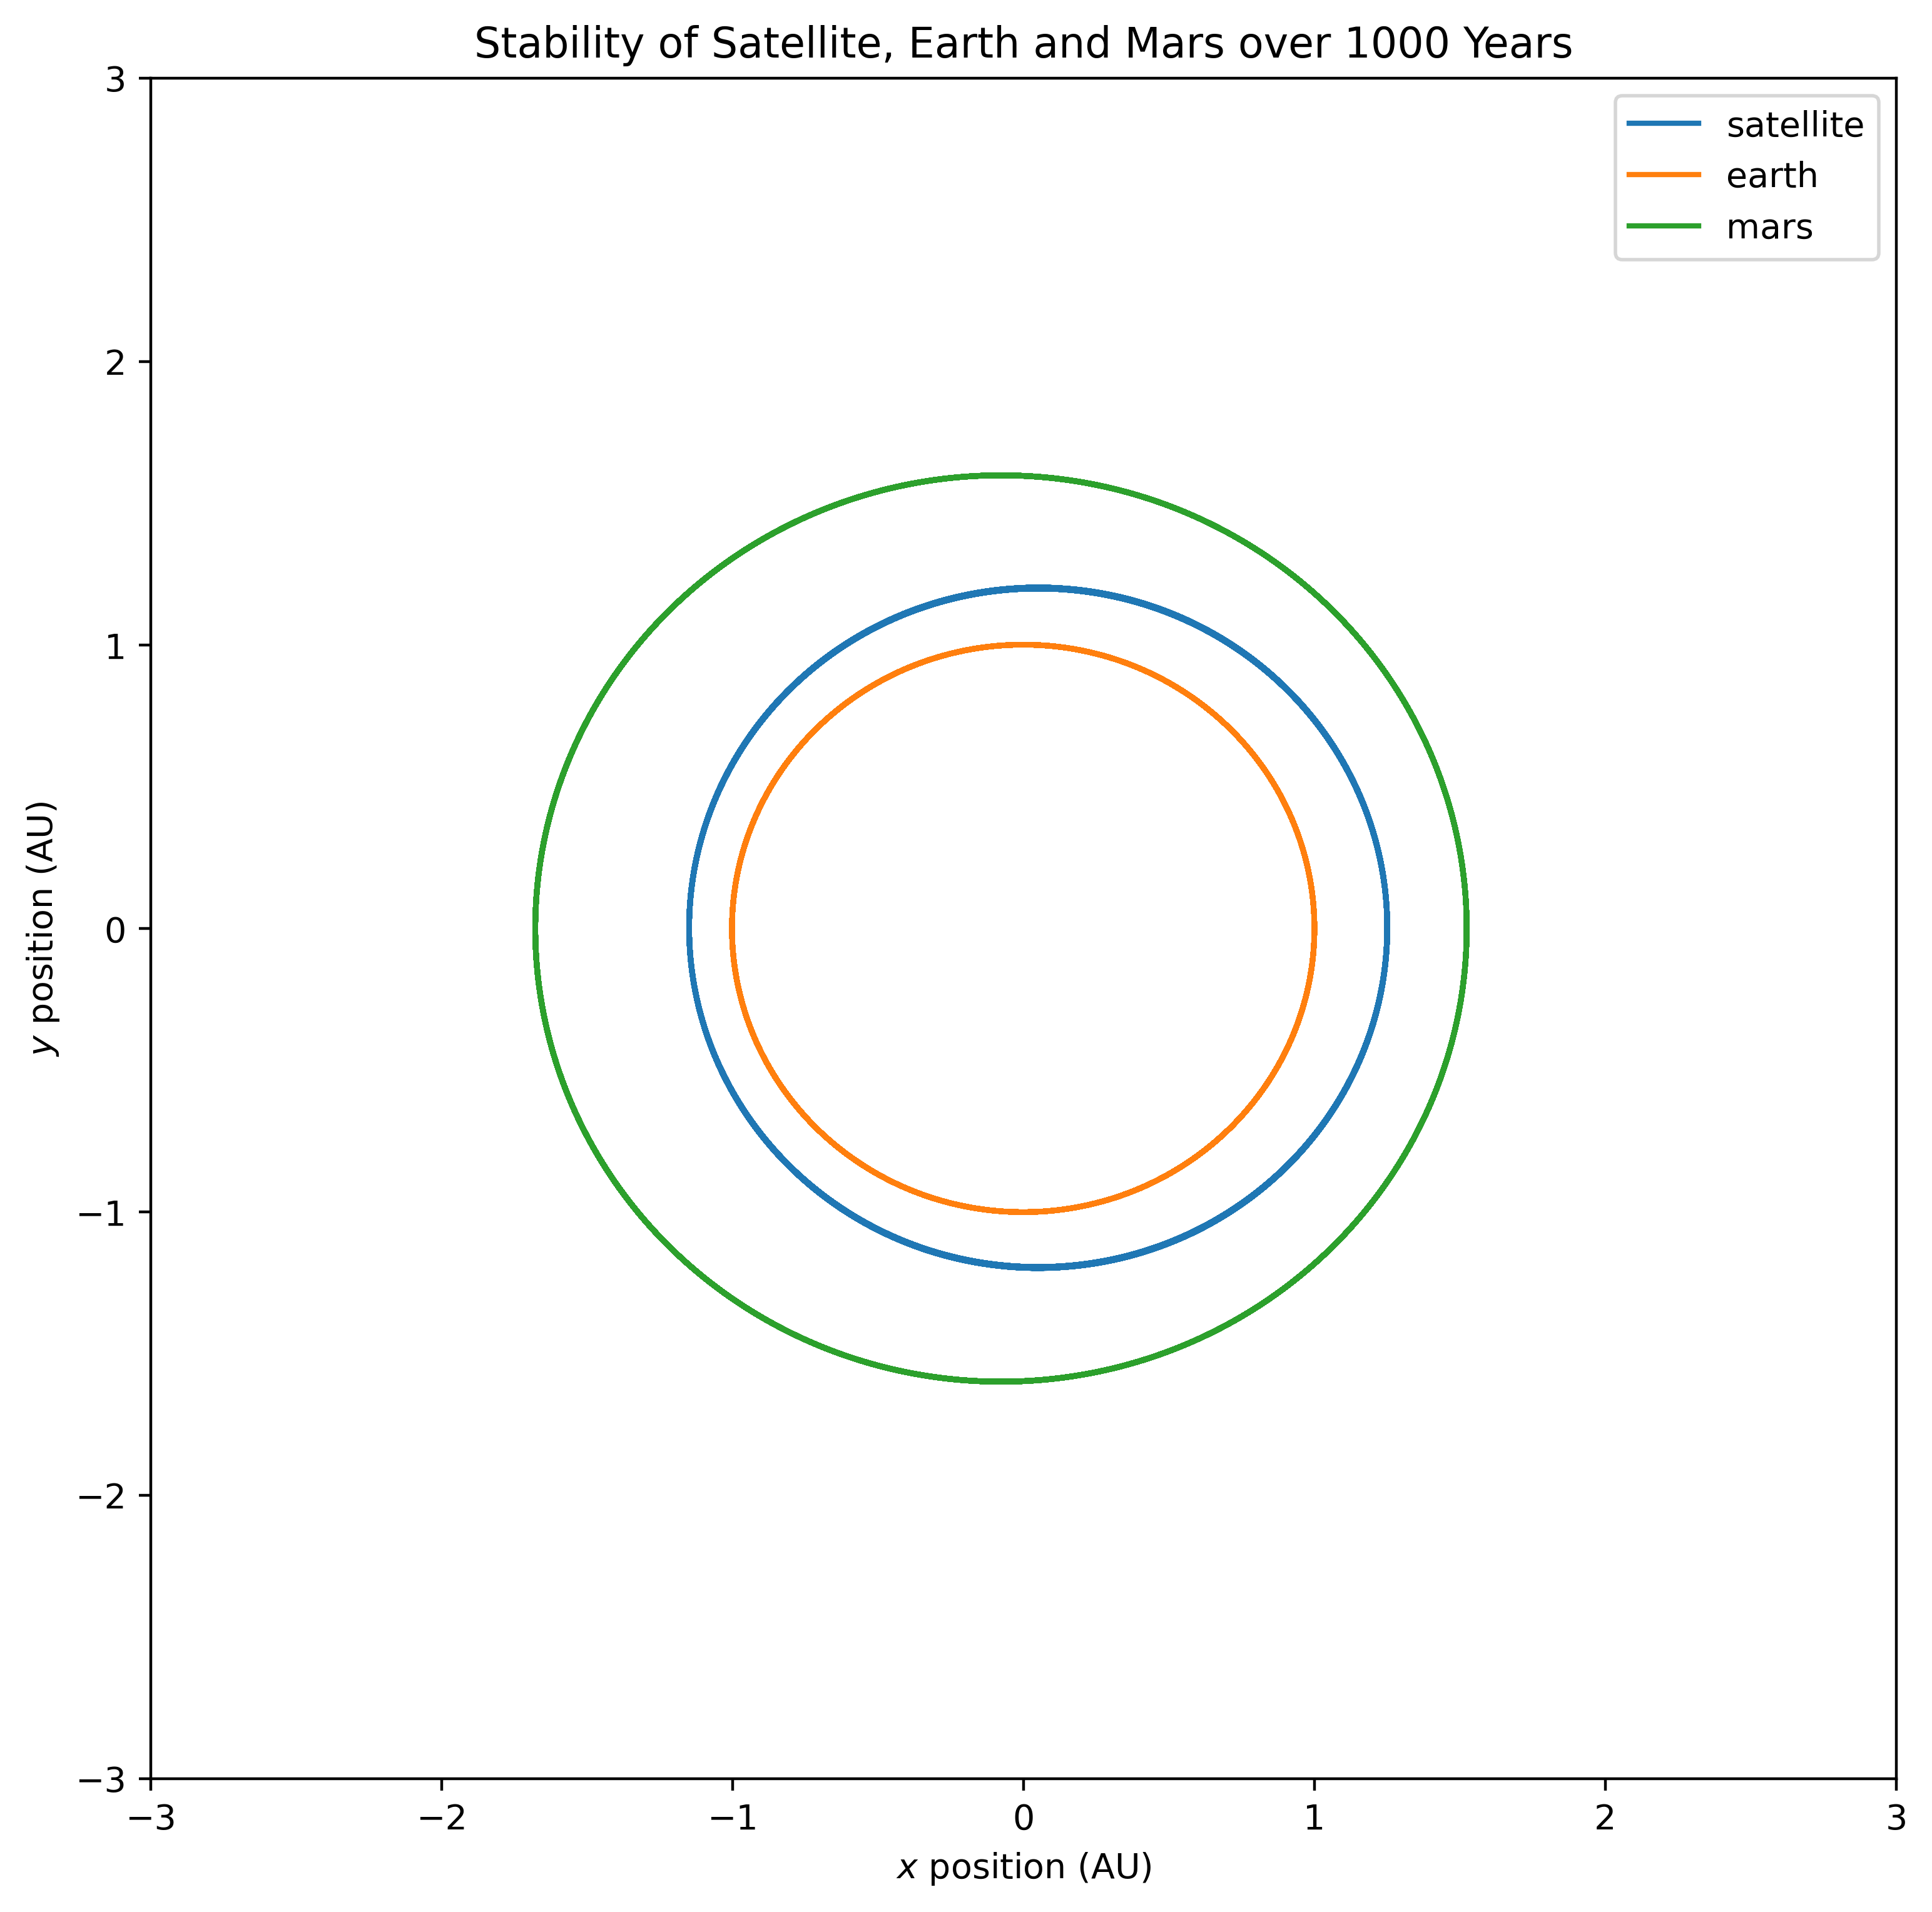

In [27]:
t = np.linspace(0, 1000,1000*100)

r0, rdot0, theta0, thetadot0 = 1.25, 0, 0,  0.7 * 2 * math.pi
r_e0, r_e_dot0, theta_e0, theta_e_dot0 = 1, 0, 0, 2 * math.pi
r_m0, r_m_dot0, theta_m0, theta_m_dot0 = 1.5237, 0, 0, 0.544 * 2 * math.pi

y0 = [r0, rdot0, theta0, thetadot0, r_e0, r_e_dot0, theta_e0, theta_e_dot0, \
     r_m0, r_m_dot0, theta_m0, theta_m_dot0]

y,info = odeint(fourBodyODEs, y0,t, args=(0,1000,math.pi/2), full_output=1)
    
r_s, r_dot_s, theta_s, theta_dot_s = y[:,0], y[:,1], y[:,2], y[:,3]
r_e, r_dot_e, theta_e, theta_dot_e = y[:,4], y[:,5], y[:,6], y[:,7]
r_m, r_dot_m, theta_m, theta_dot_m = y[:,8], y[:,9], y[:,10], y[:,11]

(x_s,y_s) = polarToCartesian(r_s,theta_s)
(x_e,y_e) = polarToCartesian(r_e,theta_e)
(x_m,y_m) = polarToCartesian(r_m,theta_m)

plt.figure(figsize=(9,9), dpi=400)

plt.title("Stability of Satellite, Earth and Mars over 1000 Years")
plt.plot(x_s,y_s, label="satellite")
plt.plot(x_e,y_e, label="earth")
plt.plot(x_m,y_m, label="mars")
plt.xlim(-3,3) 
plt.ylim(-3,3)
plt.xlabel(r"$x$ position (AU)")
plt.ylabel(r"$y$ position (AU)")
plt.legend()
plt.savefig('stability of bodies in large intra-distance orbits')

## Geostationary Orbit

In [28]:
# Let's assume satellite is geo-stationary

omega_se = 2*np.pi /(24*60*60)

r_se = (G_CONSTANT * EARTH_MASS_CONSTANT / omega_se**2)**(1/3) / rs

r_s0 = 1 + r_se

print("distance " + str(r_s0))

v_s = (2*np.pi)*1 + (omega_se * ts) * (r_se)

print("2 pi " + str(2*np.pi))
print("v_s " + str(v_s))

omega_s0 = v_s / r_s0

print(omega_s0)

distance 1.000282269459977
2 pi 6.283185307179586
v_s 6.930531540290678
6.928575814936987


## Solving for Motion in Geostationary Orbit

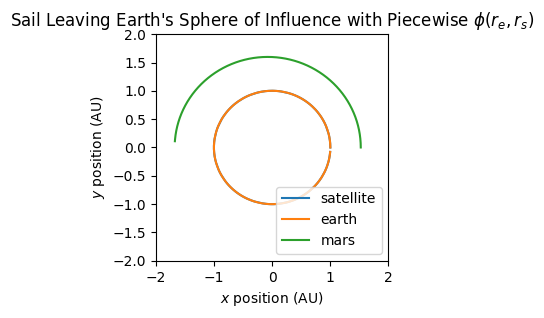

In [29]:
t = np.linspace(0, 0.99,10000)

r0, rdot0, theta0, thetadot0 = r_s0, 0, 0, omega_s0
r_e0, r_e_dot0, theta_e0, theta_e_dot0 = 1, 0, 0, 2 * math.pi
r_m0, r_m_dot0, theta_m0, theta_m_dot0 = 1.5237, 0, 0, 0.544 * 2 * math.pi

y0 = [r0, rdot0, theta0, thetadot0, r_e0, r_e_dot0, theta_e0, theta_e_dot0, \
     r_m0, r_m_dot0, theta_m0, theta_m_dot0]

r_s, r_dot_s, theta_s, theta_dot_s, \
r_e, r_dot_e, theta_e, theta_dot_e, \
r_m, r_dot_m, theta_m, theta_dot_m = \
solveAndGraph4Bodies(fourBodyODEs, y0, t, (0.9, 2e-2, math.pi/2))

## Leaving Earth's Sphere of Influence

In order to leave the Earth's sphere of influence, we must use a function for phi which allows for the increase in the orbtial apogee. To achieve this, we orient the sail such that when it is near its perigee its tangential acceleration is maximised.

In order to allow for this, we must modify the four body ODE to have phi time dependence.

In [125]:
class PerihilionAccel(object):
    def __init__(self):
        self.left = False
    def __call__(self, r, theta, r_e, theta_e, r_m, theta_m):
        # do something
        left = self.left
        
#         if (r - r_m) > 0:
#             return 0.95 * (-3/4) * np.pi
        
        # If outside of sphere of influece
        if (abs(r - r_e) > 9.24e8 / rs) or left:
            self.left = True
            return (1/2) * np.pi
        
        # If on the other side of the Earth, we increase orbital velocity
        if r > r_e:
            return (-1/4) * np.pi
        else:
            return (1/2) * np.pi

In [126]:
def fourBodyPhiFunctionODEs(x,t,R,sigma, phiFunc):  
    r = x[0]
    r_dot = x[1]
    theta = x[2]
    theta_dot = x[3]
    r_e = x[4]
    r_e_dot = x[5]
    theta_e = x[6]
    theta_e_dot = x[7]
    r_m = x[8]
    r_m_dot = x[9]
    theta_m = x[10]
    theta_m_dot = x[11]
    
    phi = phiFunc(r,theta, r_e, theta_e, r_m, theta_m)
    
    r_ddot = r * theta_dot**2 +  - (beta_1) /r**2 - beta_2 * g1(r,r_e,theta,theta_e) - beta_3 * g1(r,r_m,theta,theta_m) \
                + (r**(-2)) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi)
    
    theta_ddot = (-2/r) * r_dot * theta_dot - beta_2 * g2(r, r_e, theta, theta_e) - beta_3 * g2(r,r_m,theta,theta_m) \
                - (r**(-3)) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    r_e_ddot = r_e * (theta_e_dot)**2 - beta_1 / r_e**2 - beta_3 * g1(r_e, r_m, theta_e, theta_m)
    
    theta_e_ddot = - (2 / r_e) * r_e_dot * theta_e_dot - beta_3 * g2(r_e,r_m,theta_e,theta_m)
    
    r_m_ddot = r_m * (theta_m_dot)**2 - beta_1 / r_m**2 - beta_2 * g1(r_m, r_e, theta_m, theta_e)
    
    theta_m_ddot = - (2 / r_m) * r_m_dot * theta_m_dot - beta_2 * g2(r_m,r_e,theta_m,theta_e)
    
    
    return [r_dot, r_ddot, theta_dot, theta_ddot, r_e_dot, r_e_ddot, theta_e_dot, theta_e_ddot, \
           r_m_dot, r_m_ddot, theta_m_dot, theta_m_ddot]

## Altering Phi Function to Leave

In [127]:
def findMinDistanceToMars(r_s,r_m,theta_s,theta_m):
    minDistance = 10

    for i in range(0, len(r_s)):
        pDist = polarDistance(r_s[i],r_m[i],theta_s[i],theta_m[i])
        if pDist < minDistance:
            minDistance = pDist
    
    return minDistance

0.09067118427025889


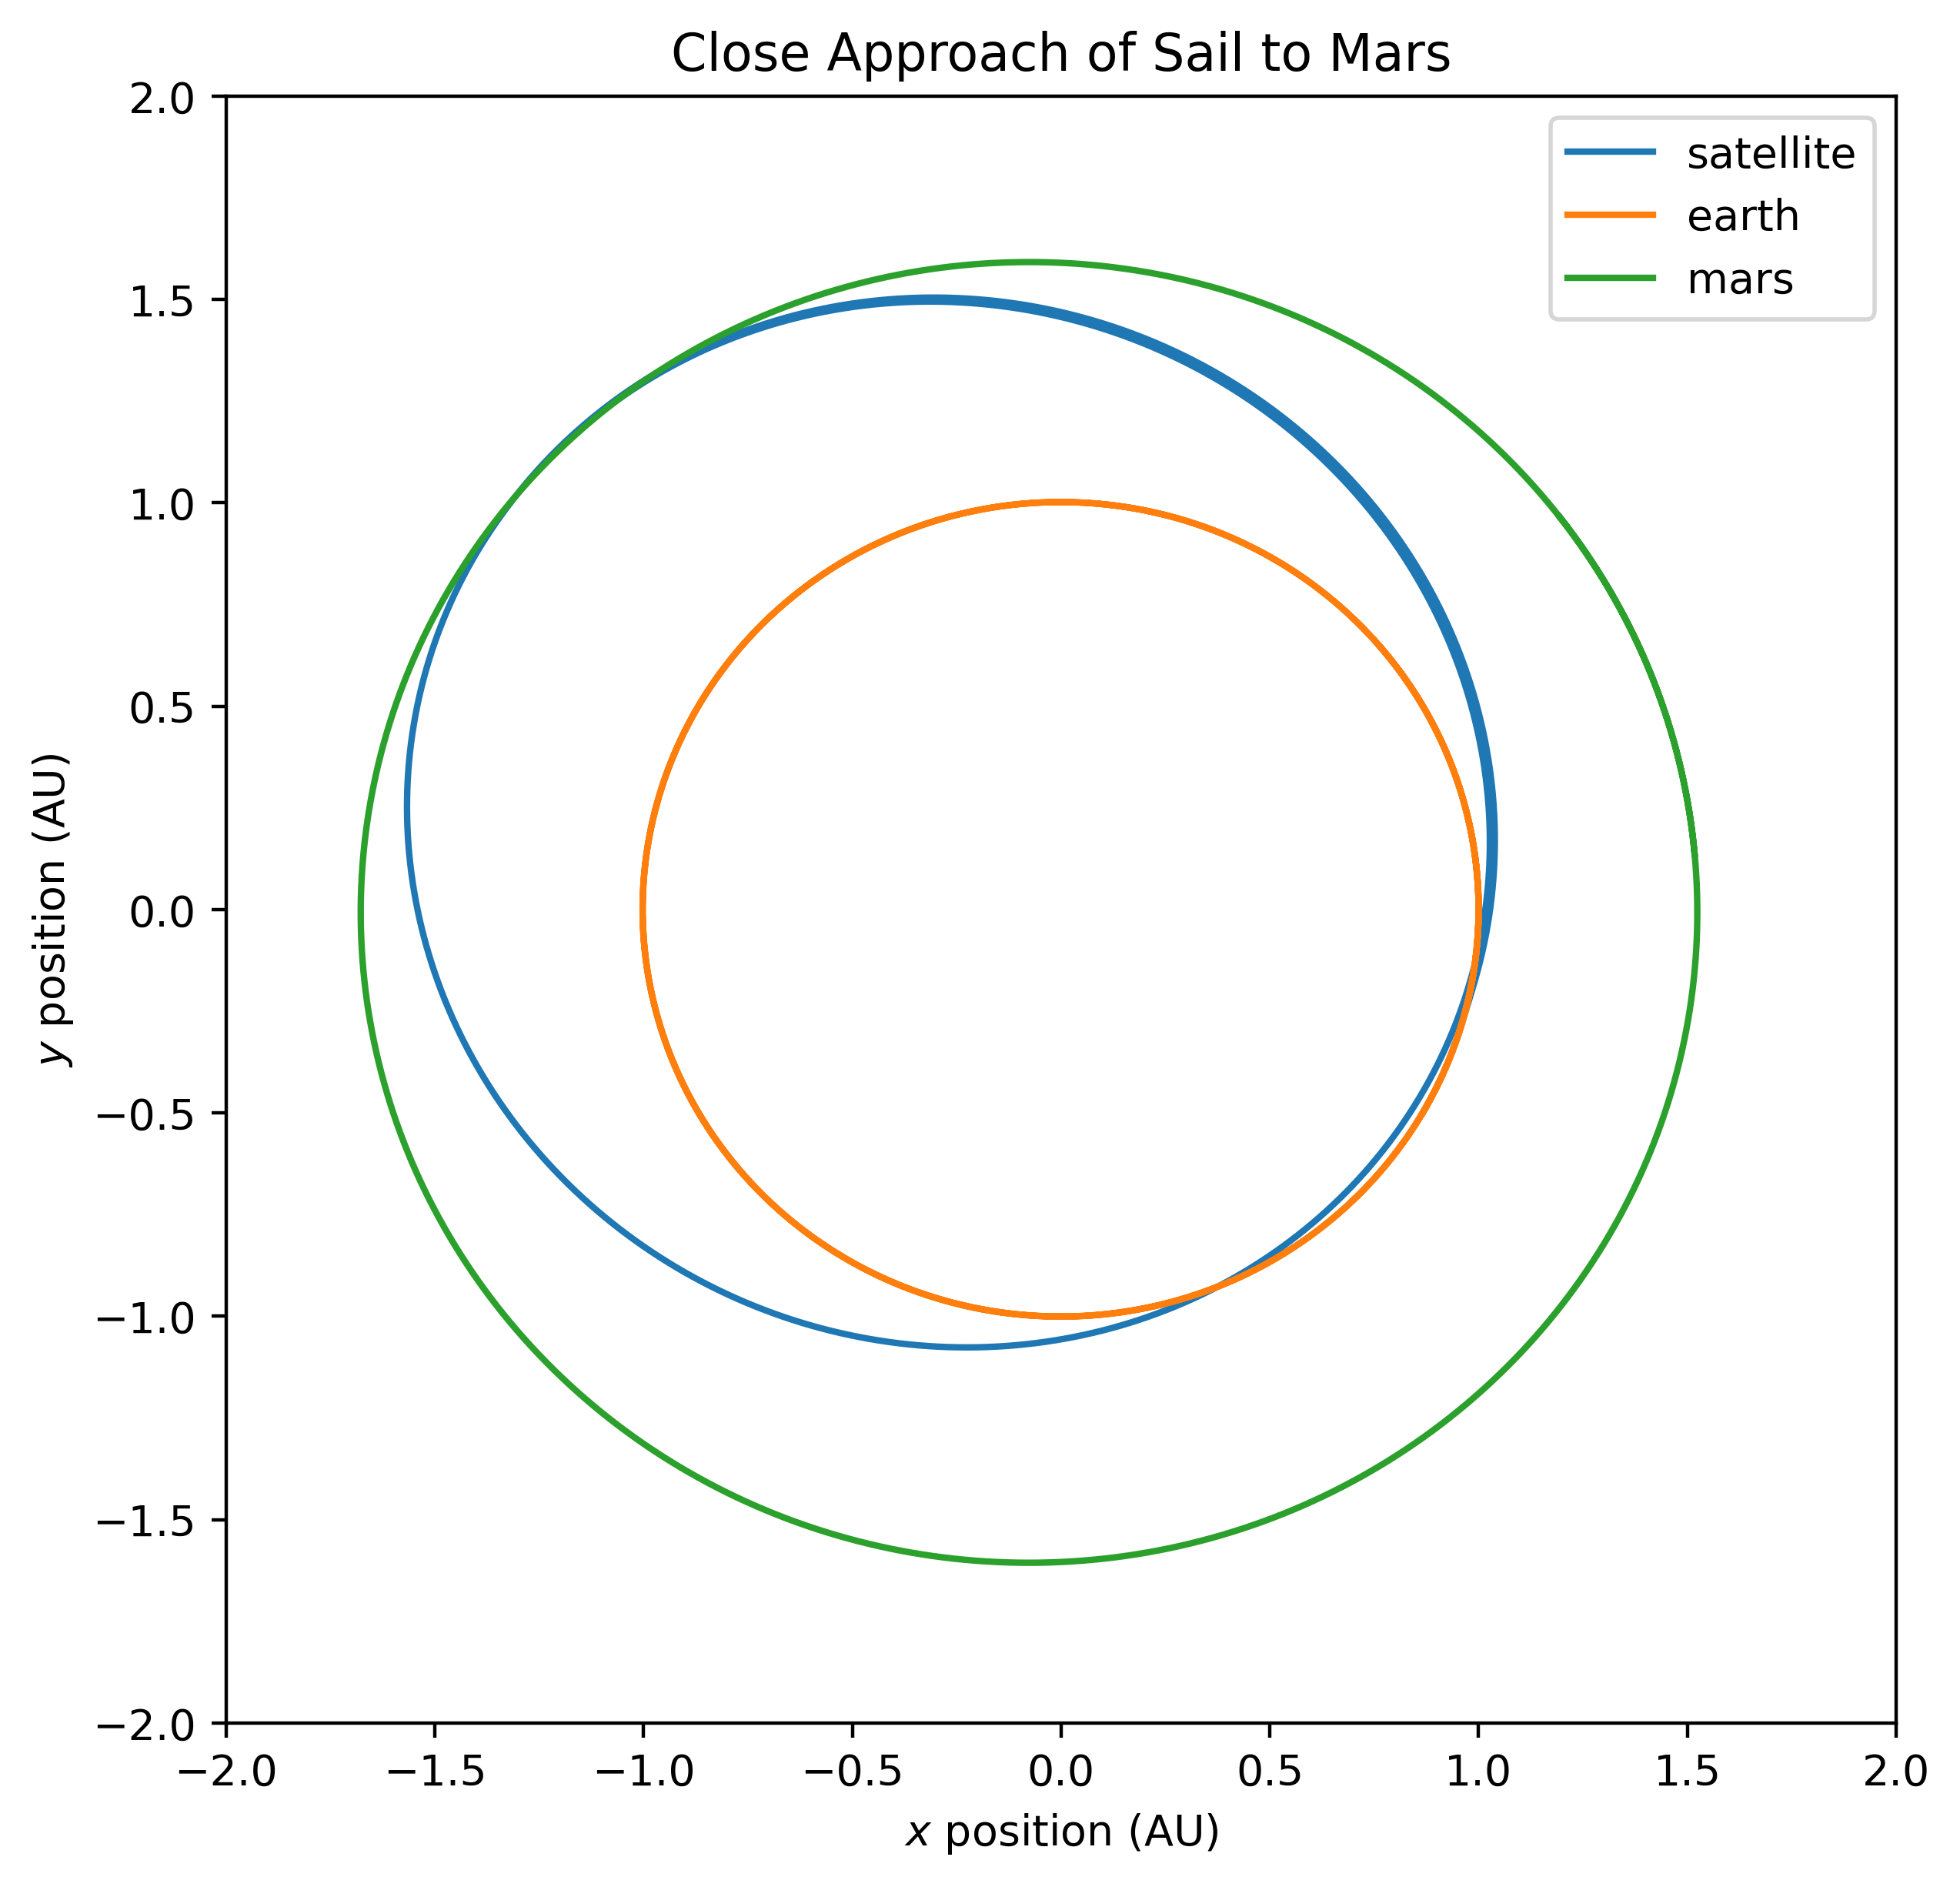

0.0011101976612228608


In [169]:
t = np.linspace(0,2.2,1000000)  

gamma = np.pi * (1 - (1/(2 * np.sqrt(2))) * np.sqrt(((r_e0/r_m0) + 1)**3))

r0, rdot0, theta0, thetadot0 = r_s0, 0, -np.pi/6, omega_s0
r_e0, r_e_dot0, theta_e0, theta_e_dot0 = 1, 0, -np.pi/6, 2 * math.pi
r_m0, r_m_dot0, theta_m0, theta_m_dot0 = 1.5237, 0, gamma-0.6833, 0.544 * 2 * math.pi

print(gamma-0.6833)

y0 = [r0, rdot0, theta0, thetadot0, r_e0, r_e_dot0, theta_e0, theta_e_dot0, \
     r_m0, r_m_dot0, theta_m0, theta_m_dot0]

perihilionAcc = PerihilionAccel()
r_s, r_dot_s, theta_s, theta_dot_s, \
r_e, r_dot_e, theta_e, theta_dot_e, \
r_m, r_dot_m, theta_m, theta_dot_m = \
solveAndGraph4Bodies(fourBodyPhiFunctionODEs, y0, t, (0.9, 6.0371e-4, perihilionAcc))

minDist = findMinDistanceToMars(r_s,r_m,theta_s,theta_m)

print(minDist)

## Finding Initial Conditions for Mars Capture

We take our angular alignment, $\gamma$ to be that optimal for a Hohmann transfer orbit which is given by:

$$\gamma = \pi \left(1 - \frac{1}{2 \sqrt{2}} \sqrt{\left(\frac{r_1}{r_2} + 1\right)^3} \right)$$

We then set Mars to be that alignment from Earth.

In [34]:
gamma = np.pi * (1 - (1/(2 * np.sqrt(2))) * np.sqrt(((r_e0/r_m0) + 1)**3))

In [35]:
r0, rdot0, theta0, thetadot0 = r_s0, 0, 0, omega_s0
r_e0, r_e_dot0, theta_e0, theta_e_dot0 = 1, 0, 0, 2 * math.pi
r_m0, r_m_dot0, theta_m_dot0 = 1.5237, 0, 0.544 * 2 * math.pi

gamma = np.pi * (1 - (1/(2 * np.sqrt(2))) * np.sqrt(((r_e0/r_m0) + 1)**3))
print(gamma)

theta_m0 = gamma

y0 = [r0, rdot0, theta0, thetadot0, r_e0, r_e_dot0, theta_e0, theta_e_dot0, \
     r_m0, r_m_dot0, theta_m0, theta_m_dot0]

0.7739711842702589


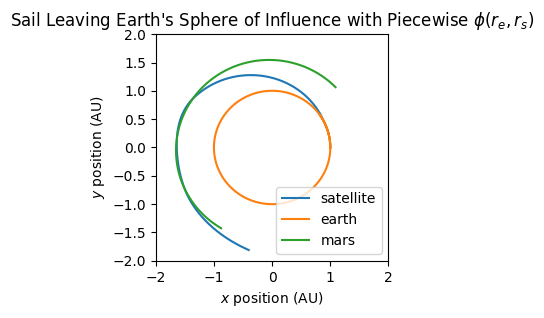

0.0021880272324396287


In [36]:
perihilionAcc = PerihilionAccel()
r_s, r_dot_s, theta_s, theta_dot_s, \
r_e, r_dot_e, theta_e, theta_dot_e, \
r_m, r_dot_m, theta_m, theta_dot_m = \
solveAndGraph4Bodies(fourBodyPhiFunctionODEs, y0, t, (0.9, 6.102e-4, perihilionAcc))

minDist = findMinDistanceToMars(r_s,r_m,theta_s,theta_m)
print(minDist)

## Finding Piecewise Function for Mars Capture

In [37]:
deltav1lin = np.sqrt(beta_1 / r_e0) \
            * (np.sqrt(2 * r_m0 / (r_e0 + r_m0)) - 1)

deltav2lin = np.sqrt(beta_1 / r_m0) \
            * (1 - np.sqrt(2 * r_e0 / (r_e0 + r_m0)))

print(deltav1)
print(deltav2)

NameError: name 'deltav1' is not defined

In [ ]:
class PieceWiseAccel(object):
    def __init__(self, theta_dot0):
        self.left = False
        self.theta_dot0 = theta_dot0
    def __call__(self, r, theta, r_e, theta_e, r_m, theta_m, theta_dot, theta_m_dot):
        # do something
        left = self.left
        
        # If outside of sphere of influece
        if (abs(r - r_e) > 9.24e8 / rs) or left:
            
            self.left = True
#             print(theta_dot*r)
#             print((1/r) * (self.theta_dot0 + deltav1lin))
            
            if (theta_dot < (1/r) * (self.theta_dot0 + deltav1lin) - 1):
                return (-1/4) * math.pi
            else:
#                 print("returning this")
                return (1/2) * math.pi
        
        # If on the other side of the Earth, we increase orbital velocity
        if r > r_e:
            return (-1/4) * np.pi
        else:
            return (1/2) * np.pi

In [ ]:
def fourBodyPhiFunctionODEs(x,t,R,sigma, phiFunc):  
    r = x[0]
    r_dot = x[1]
    theta = x[2]
    theta_dot = x[3]
    r_e = x[4]
    r_e_dot = x[5]
    theta_e = x[6]
    theta_e_dot = x[7]
    r_m = x[8]
    r_m_dot = x[9]
    theta_m = x[10]
    theta_m_dot = x[11]
    
    phi = phiFunc(r,theta, r_e, theta_e, r_m, theta_m, theta_dot, theta_m_dot)
    
    r_ddot = r * theta_dot**2 +  - (beta_1) /r**2 - beta_2 * g1(r,r_e,theta,theta_e) - beta_3 * g1(r,r_m,theta,theta_m) \
                + (r**(-2)) * (alpha / sigma) * (1 + R * np.cos(2 * phi)) * np.cos(phi)
    
    theta_ddot = (-2/r) * r_dot * theta_dot - beta_2 * g2(r, r_e, theta, theta_e) - beta_3 * g2(r,r_m,theta,theta_m) \
                - (r**(-3)) * (alpha / sigma) * R * np.sin(2 * phi) * np.cos(phi)
    
    r_e_ddot = r_e * (theta_e_dot)**2 - beta_1 / r_e**2 - beta_3 * g1(r_e, r_m, theta_e, theta_m)
    
    theta_e_ddot = - (2 / r_e) * r_e_dot * theta_e_dot - beta_3 * g2(r_e,r_m,theta_e,theta_m)
    
    r_m_ddot = r_m * (theta_m_dot)**2 - beta_1 / r_m**2 - beta_2 * g1(r_m, r_e, theta_m, theta_e)
    
    theta_m_ddot = - (2 / r_m) * r_m_dot * theta_m_dot - beta_2 * g2(r_m,r_e,theta_m,theta_e)
    
    
    return [r_dot, r_ddot, theta_dot, theta_ddot, r_e_dot, r_e_ddot, theta_e_dot, theta_e_ddot, \
           r_m_dot, r_m_ddot, theta_m_dot, theta_m_ddot]

In [ ]:
# t = np.linspace(0,1,500000)  
# accelFunc = PieceWiseAccel(thetadot0)
# _ = solveAndGraph4Bodies(fourBodyPhiFunctionODEs, y0, t, (0.9, 2e-3, accelFunc))